# **Estimating Implied Volatility Using Market Data (MSFT)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tcn
from tcn import TCN

## **Section 1: Data Loading and preprocessing**

In [3]:
df = pd.read_csv("/content/Microsoft Options.csv")

In [4]:
# Basic feature engineering
df['Days to Expiration'] = pd.to_numeric(df['Days to Expiration'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
df['openInterest'] = pd.to_numeric(df['openInterest'], errors='coerce')
df['impliedVolatility'] = pd.to_numeric(df['impliedVolatility'], errors='coerce')
df['spread'] = (df['ask'] - df['bid']) / ((df['ask'] + df['bid']) / 2)
df['moneyness'] = df['Stock Price'] / df['strike']
df['inTheMoney_dummy'] = df['inTheMoney'].astype(int)

# American option-specific features
df['dividend_impact'] = df['Dividend Yield'] * df['Days to Expiration']/365
df['margin_req'] = np.where(
    df['Type'] == 'Call',
    np.where(
        df['inTheMoney'],
        df['Stock Price'] * 0.20,  # 20% for ITM calls
        df['Stock Price'] * 0.10   # 10% for OTM calls
    ),
    np.where(
        df['inTheMoney'],
        (df['strike'] - df['Stock Price']) + (df['Stock Price'] * 0.20),  # For ITM puts
        df['strike'] * 0.10  # 10% of strike for OTM puts
    )
)
df['early_exercise_premium'] = np.where(
    df['Dividend Yield'] > 0,  # If there are dividends
    (df['Dividend Yield'] * df['Stock Price'] *
     np.exp(-df['Treasury Rate'] * df['Days to Expiration']/365)),  # PV of dividends
    0  # No early exercise premium for no dividends
)

In [5]:
# Filter dataset for modeling IV
df_iv_model = df[
    (df['Type'] == 'Call') &
    df[['impliedVolatility', 'spread', 'moneyness', 'Days to Expiration', 'volume', 'openInterest']].notnull().all(axis=1)
].copy()
df_iv_model = df_iv_model[(df_iv_model['spread'] > 0) & (df_iv_model['spread'] < 2)]

# Define features
basic_features = ['spread', 'moneyness', 'Days to Expiration', 'volume', 'openInterest', 'inTheMoney_dummy']
enhanced_features = basic_features + ['dividend_impact', 'margin_req', 'early_exercise_premium']
X = df_iv_model[enhanced_features]
y = df_iv_model['impliedVolatility']

print("Dataset shape:", df_iv_model.shape)
print("Features:", enhanced_features)

Dataset shape: (1214, 27)
Features: ['spread', 'moneyness', 'Days to Expiration', 'volume', 'openInterest', 'inTheMoney_dummy', 'dividend_impact', 'margin_req', 'early_exercise_premium']


## **Section 2: Exploratory Data Analysis**

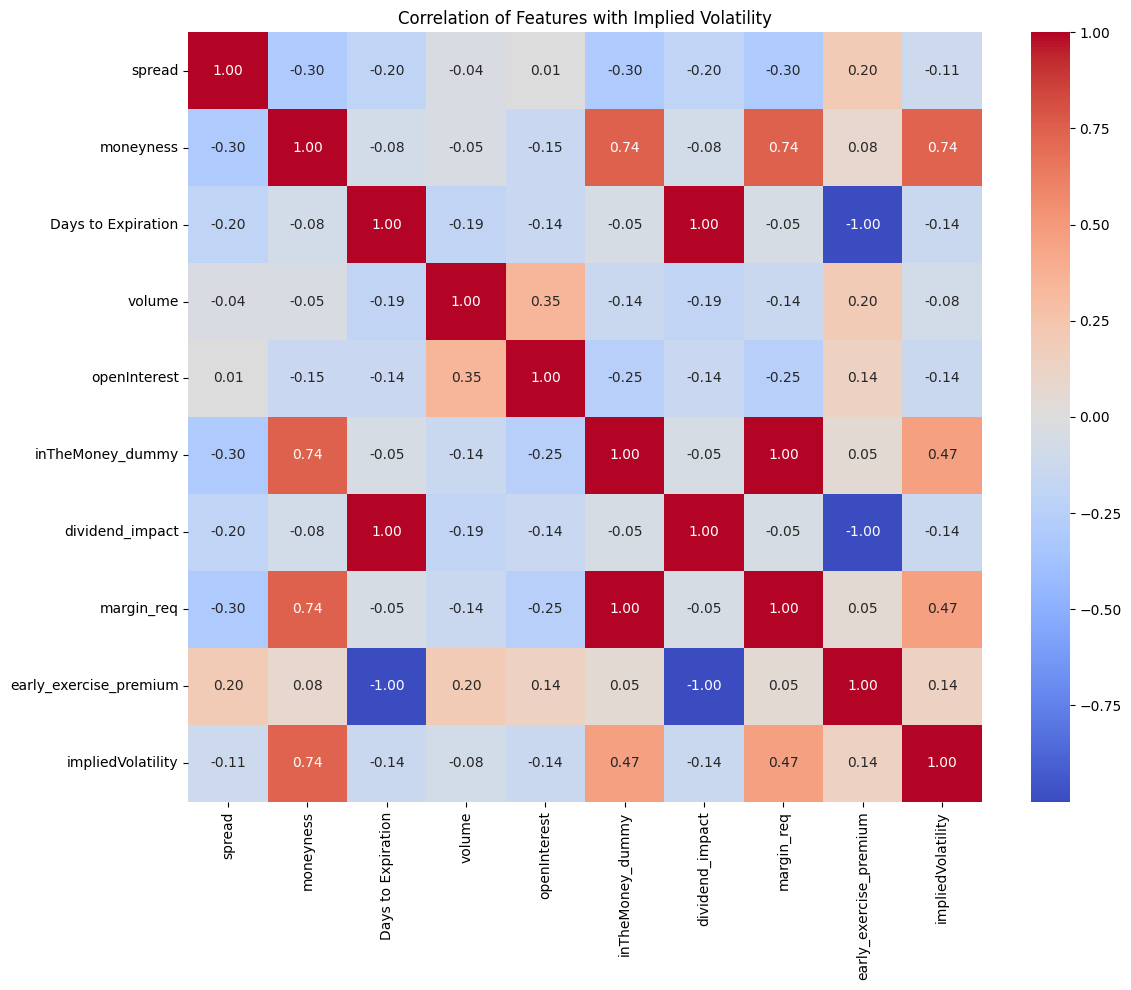

In [6]:
# Key visualizations for implied volatility

# 1. Correlation heatmap (essential for understanding relationships)
plt.figure(figsize=(12, 10))
correlation = df_iv_model[enhanced_features + ['impliedVolatility']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Implied Volatility")
plt.tight_layout()
plt.show()

<ipython-input-7-d1e24ba95942>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_iv_model, x='moneyness', y='impliedVolatility', ci=None)


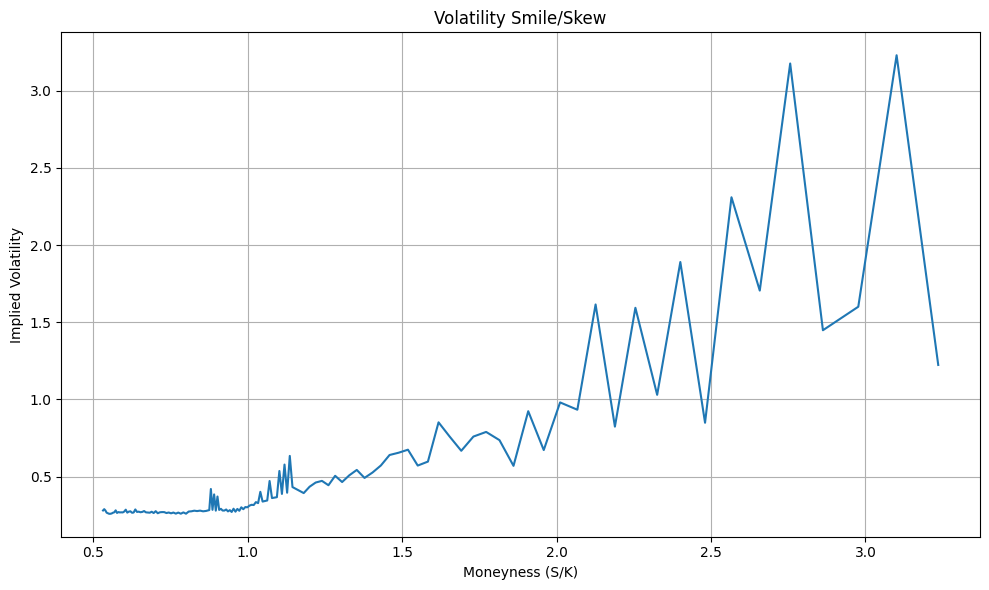

In [7]:
# 2. Volatility smile/skew (critical for option pricing)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_iv_model, x='moneyness', y='impliedVolatility', ci=None)
plt.title('Volatility Smile/Skew')
plt.xlabel('Moneyness (S/K)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# 3. 3D visualization (valuable for seeing the volatility surface)
fig_3d = px.scatter_3d(
    df_iv_model.sample(min(1000, len(df_iv_model))),  # Sample to prevent overplotting
    x='moneyness',
    y='Days to Expiration',
    z='impliedVolatility',
    color='impliedVolatility',
    color_continuous_scale='Viridis',
    title='3D Visualization of Implied Volatility Surface',
    labels={
        'moneyness': 'Moneyness (S/K)',
        'Days to Expiration': 'Days to Expiration',
        'impliedVolatility': 'Implied Volatility'
    }
)
fig_3d.update_layout(scene=dict(
    xaxis_title='Moneyness',
    yaxis_title='Days to Expiration',
    zaxis_title='Implied Volatility'
))
fig_3d.show()

## **Section 3: Model Training and Evaluation**

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Define traditional ML models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
    "Lasso": Lasso(alpha=0.01),
    "Ridge": Ridge(alpha=0.01),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate traditional ML models
results = {}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}

In [11]:
# Neural Network with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
    callbacks=[early_stop]
)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)
results["Neural Network (Keras)"] = {"MAE": mae_nn, "MSE": mse_nn, "RMSE": rmse_nn, "R2 Score": r2_nn}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [12]:
# LSTM model
# Reshape input for sequence models
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(
    X_train_seq, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
results["LSTM"] = {"MAE": mae_lstm, "MSE": mse_lstm, "RMSE": rmse_lstm, "R2 Score": r2_lstm}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [13]:
# TCN model
try:
    tcn_model = Sequential()
    tcn_model.add(TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4, 8],
                     return_sequences=False, input_shape=(1, X_train_scaled.shape[1])))
    tcn_model.add(Dense(1))
    tcn_model.compile(optimizer='adam', loss='mse')

    tcn_model.fit(
        X_train_seq, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_tcn = tcn_model.predict(X_test_seq).flatten()
    mae_tcn = mean_absolute_error(y_test, y_pred_tcn)
    mse_tcn = mean_squared_error(y_test, y_pred_tcn)
    rmse_tcn = np.sqrt(mse_tcn)
    r2_tcn = r2_score(y_test, y_pred_tcn)
    results["TCN"] = {"MAE": mae_tcn, "MSE": mse_tcn, "RMSE": rmse_tcn, "R2 Score": r2_tcn}
except Exception as e:
    print(f"Error training TCN: {e}")
    results["TCN"] = {"MAE": np.nan, "MSE": np.nan, "RMSE": np.nan, "R2 Score": np.nan}


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


## **Section 4: Results Analysis**


Model Comparison (Ranked by R2 Score):
                             MAE       MSE      RMSE  R2 Score
Gradient Boosting       0.050957  0.028698  0.169405  0.757993
MLP                     0.063325  0.030939  0.175894  0.739099
KNN                     0.053164  0.035084  0.187308  0.704138
Random Forest           0.047751  0.036440  0.190893  0.692704
TCN                     0.095390  0.040273  0.200681  0.660385
LSTM                    0.087987  0.043693  0.209028  0.631546
XGBoost                 0.054022  0.048102  0.219322  0.594361
Ridge                   0.102208  0.048773  0.220845  0.588706
Linear Regression       0.102325  0.048775  0.220850  0.588687
SVR                     0.085544  0.048790  0.220884  0.588562
Neural Network (Keras)  0.097258  0.051985  0.228002  0.561618
Lasso                   0.101048  0.052884  0.229966  0.554033
Decision Tree           0.059881  0.069599  0.263817  0.413078

Best model: Gradient Boosting with R² Score: 0.7580


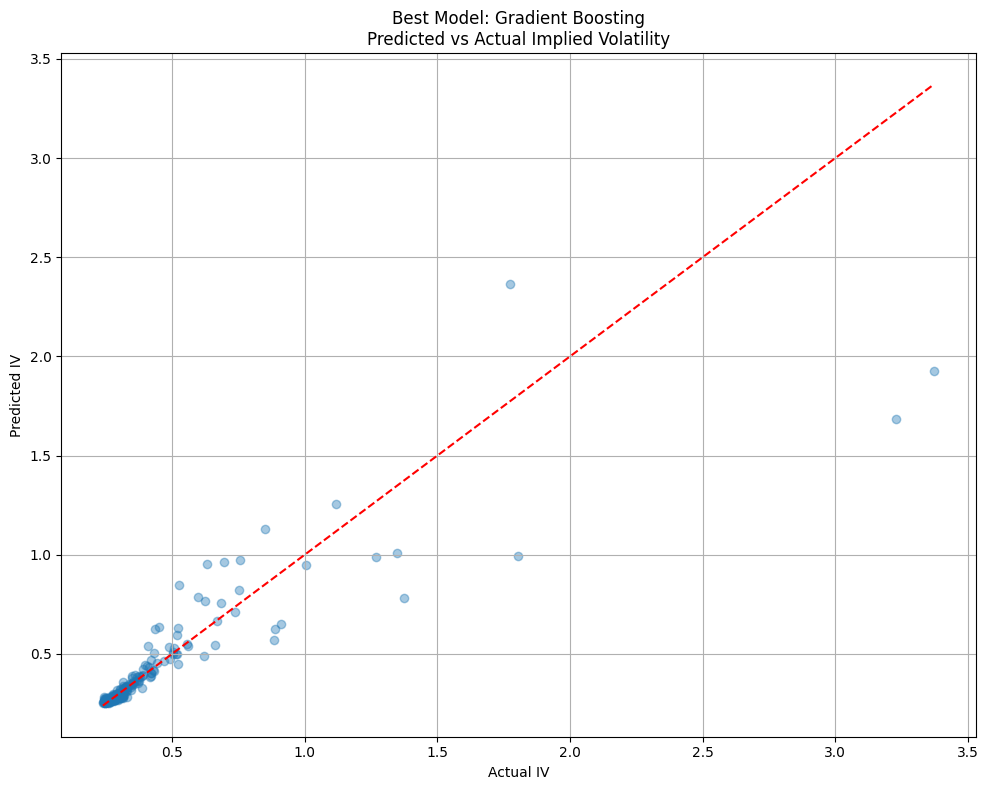

In [14]:
# Convert results to DataFrame and rank
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("R2 Score", ascending=False)
print("\nModel Comparison (Ranked by R2 Score):")
print(results_df)

# Find the best model
best_model_name = results_df.index[0]
print(f"\nBest model: {best_model_name} with R² Score: {results_df.loc[best_model_name, 'R2 Score']:.4f}")

# Plot predicted vs actual for the best model
plt.figure(figsize=(10, 8))
if best_model_name == "Neural Network (Keras)":
    best_pred = y_pred_nn
elif best_model_name == "LSTM":
    best_pred = y_pred_lstm
elif best_model_name == "TCN":
    best_pred = y_pred_tcn
else:
    best_pred = models[best_model_name].predict(X_test_scaled)

plt.scatter(y_test, best_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual IV")
plt.ylabel("Predicted IV")
plt.title(f"Best Model: {best_model_name}\nPredicted vs Actual Implied Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Section 5: Model Interpretability**

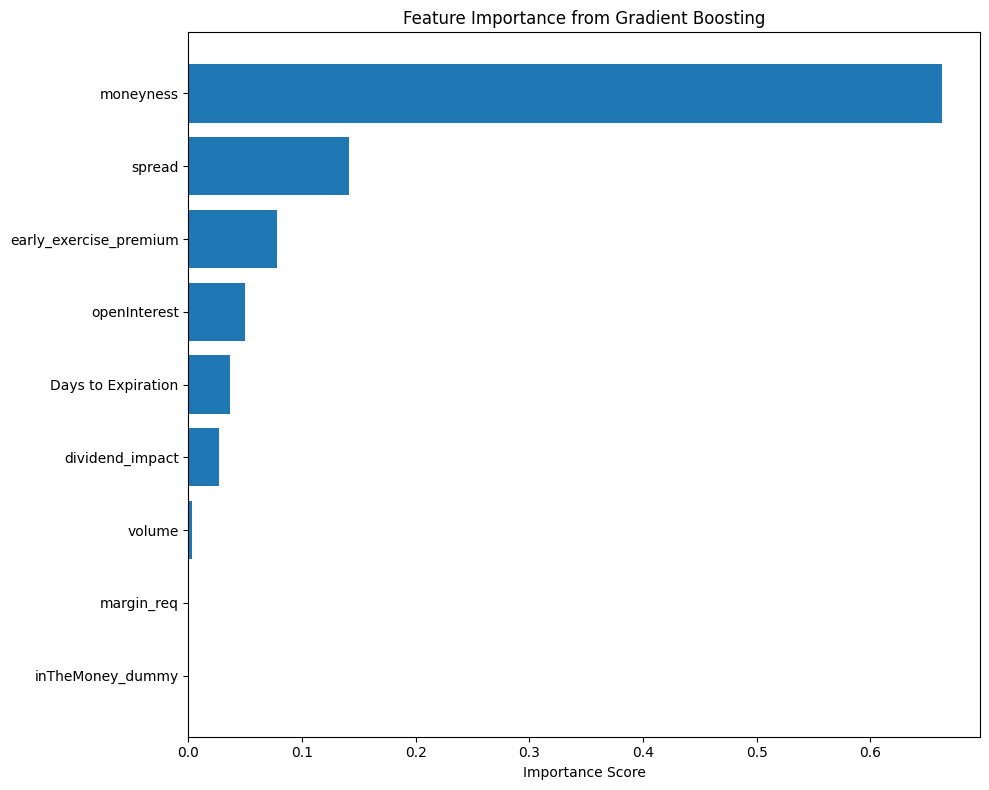

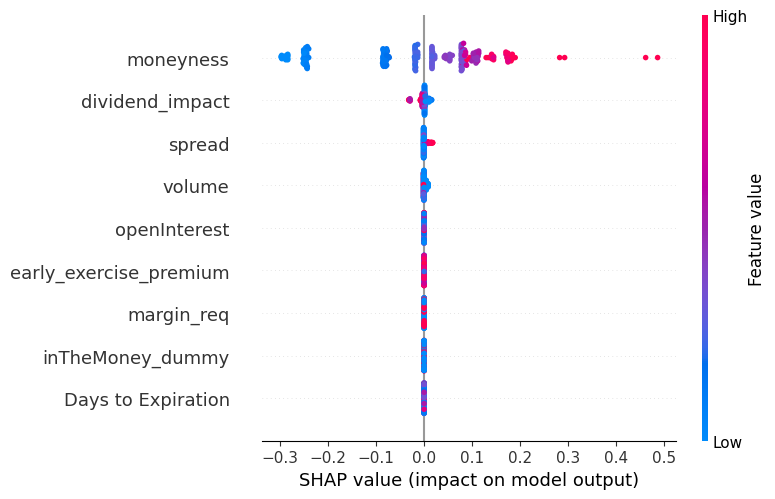

<Figure size 640x480 with 0 Axes>

In [15]:
# Feature importance for tree-based models
if best_model_name in ["Random Forest", "XGBoost", "Gradient Boosting", "Decision Tree"]:
    best_model = models[best_model_name]

    # Calculate feature importance
    importances = best_model.feature_importances_
    feature_names = X.columns

    # Sort features by importance
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f"Feature Importance from {best_model_name}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# SHAP analysis for the best model
try:
    # Create explainer
    explainer = shap.Explainer(best_model, X_train)

    # Calculate SHAP values
    shap_values = explainer(X_test)

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in SHAP analysis: {e}")

## **Section 6: Additional Feature Engineering for Model Enhancement**

In [16]:
# 1. Create polynomial features for moneyness and transformations
df_iv_model['moneyness_squared'] = df_iv_model['moneyness'] ** 2
df_iv_model['moneyness_cubed'] = df_iv_model['moneyness'] ** 3
df_iv_model['log_days_to_expiration'] = np.log1p(df_iv_model['Days to Expiration'])  # log(1+x) to handle zeros
df_iv_model['sqrt_days_to_expiration'] = np.sqrt(df_iv_model['Days to Expiration'])


In [17]:
# 2. Create interaction terms
df_iv_model['moneyness_x_early_exercise'] = df_iv_model['moneyness'] * df_iv_model['early_exercise_premium']
df_iv_model['moneyness_x_days'] = df_iv_model['moneyness'] * df_iv_model['Days to Expiration']
df_iv_model['spread_x_moneyness'] = df_iv_model['spread'] * df_iv_model['moneyness']

In [18]:
# Update the feature list with transformed and interaction features
transformed_features = enhanced_features + [
    'moneyness_squared', 'moneyness_cubed',
    'log_days_to_expiration', 'sqrt_days_to_expiration',
    'moneyness_x_early_exercise', 'moneyness_x_days', 'spread_x_moneyness'
]

print("\nEnhanced feature set:")
print(transformed_features)

# Use the transformed features for modeling
X_transformed = df_iv_model[transformed_features]


Enhanced feature set:
['spread', 'moneyness', 'Days to Expiration', 'volume', 'openInterest', 'inTheMoney_dummy', 'dividend_impact', 'margin_req', 'early_exercise_premium', 'moneyness_squared', 'moneyness_cubed', 'log_days_to_expiration', 'sqrt_days_to_expiration', 'moneyness_x_early_exercise', 'moneyness_x_days', 'spread_x_moneyness']


In [19]:
# 3. Segmented Modelling (Defining segments based on moneyness)
def classify_moneyness(x):
    if x < 0.8:
        return 'Deep OTM'
    elif x < 0.95:
        return 'OTM'
    elif x < 1.05:
        return 'ATM'
    elif x < 1.2:
        return 'ITM'
    else:
        return 'Deep ITM'

df_iv_model['moneyness_segment'] = df_iv_model['moneyness'].apply(classify_moneyness)

# Function to train and evaluate model on a specific segment
def train_segment_model(segment_name, X_data, y_data):
    # Filter data for the segment
    segment_mask = df_iv_model['moneyness_segment'] == segment_name
    X_segment = X_data[segment_mask]
    y_segment = y_data[segment_mask]

    # Skip if not enough data
    if len(X_segment) < 50:
        print(f"Skipping {segment_name} segment as it only has {len(X_segment)} samples")
        return None, None

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_segment, y_segment, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Gradient Boosting (best performing model from previous analysis)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{segment_name} segment: R² = {r2:.4f}, RMSE = {rmse:.4f}, Samples = {len(X_segment)}")

    # Feature importance for this segment
    if hasattr(model, 'feature_importances_'):
        segment_importances = pd.DataFrame({
            'Feature': X_segment.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False).head(5)

        print(f"Top 5 features for {segment_name} segment:")
        print(segment_importances)

    return model, scaler

In [20]:
# Train and evaluate models on different segments
segment_models = {}
segment_scalers = {}
segments = df_iv_model['moneyness_segment'].unique()

print("\nTraining segmented models:")
for segment in segments:
    print(f"\nProcessing {segment} segment...")
    model, scaler = train_segment_model(segment, X_transformed, y)
    if model is not None:
        segment_models[segment] = model
        segment_scalers[segment] = scaler

# Function to predict using the appropriate segment model
def predict_with_segments(X_new, segment_column):
    predictions = np.zeros(len(X_new))

    for segment, model in segment_models.items():
        segment_mask = segment_column == segment
        if np.any(segment_mask) and model is not None:
            scaler = segment_scalers[segment]
            X_segment = X_new[segment_mask]
            X_segment_scaled = scaler.transform(X_segment)
            predictions[segment_mask] = model.predict(X_segment_scaled)

    return predictions


Training segmented models:

Processing Deep ITM segment...
Deep ITM segment: R² = 0.3788, RMSE = 0.3501, Samples = 299
Top 5 features for Deep ITM segment:
                       Feature  Importance
13  moneyness_x_early_exercise    0.324673
15          spread_x_moneyness    0.110658
1                    moneyness    0.106855
14            moneyness_x_days    0.091138
10             moneyness_cubed    0.087768

Processing ITM segment...
ITM segment: R² = 0.9859, RMSE = 0.0119, Samples = 127
Top 5 features for ITM segment:
                       Feature  Importance
8       early_exercise_premium    0.361930
2           Days to Expiration    0.136003
13  moneyness_x_early_exercise    0.134967
14            moneyness_x_days    0.129477
6              dividend_impact    0.093733

Processing ATM segment...
ATM segment: R² = 0.8600, RMSE = 0.0075, Samples = 156
Top 5 features for ATM segment:
                       Feature  Importance
14            moneyness_x_days    0.204462
1            

In [21]:
# Now let's compare the combined segmented approach with the global model

# First train a global model using the same transformed features
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

scaler_global = StandardScaler()
X_train_global_scaled = scaler_global.fit_transform(X_train_global)
X_test_global_scaled = scaler_global.transform(X_test_global)

global_model = GradientBoostingRegressor(random_state=42)
global_model.fit(X_train_global_scaled, y_train_global)
y_pred_global = global_model.predict(X_test_global_scaled)

In [22]:
# Test segment prediction
segments_test = df_iv_model.loc[y_test_global.index, 'moneyness_segment']
y_pred_segmented = predict_with_segments(X_test_global, segments_test)

# Compare results
r2_global = r2_score(y_test_global, y_pred_global)
rmse_global = np.sqrt(mean_squared_error(y_test_global, y_pred_global))

# Calculate metrics for segmented predictions (only where predictions were made)
valid_mask = y_pred_segmented != 0
if np.any(valid_mask):
    r2_segmented = r2_score(y_test_global[valid_mask], y_pred_segmented[valid_mask])
    rmse_segmented = np.sqrt(mean_squared_error(y_test_global[valid_mask], y_pred_segmented[valid_mask]))
else:
    r2_segmented = np.nan
    rmse_segmented = np.nan

print("\nModel Performance Comparison:")
print(f"Global model:     R² = {r2_global:.4f}, RMSE = {rmse_global:.4f}")
print(f"Segmented models: R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")


Model Performance Comparison:
Global model:     R² = 0.6274, RMSE = 0.2102
Segmented models: R² = 0.8942, RMSE = 0.1120


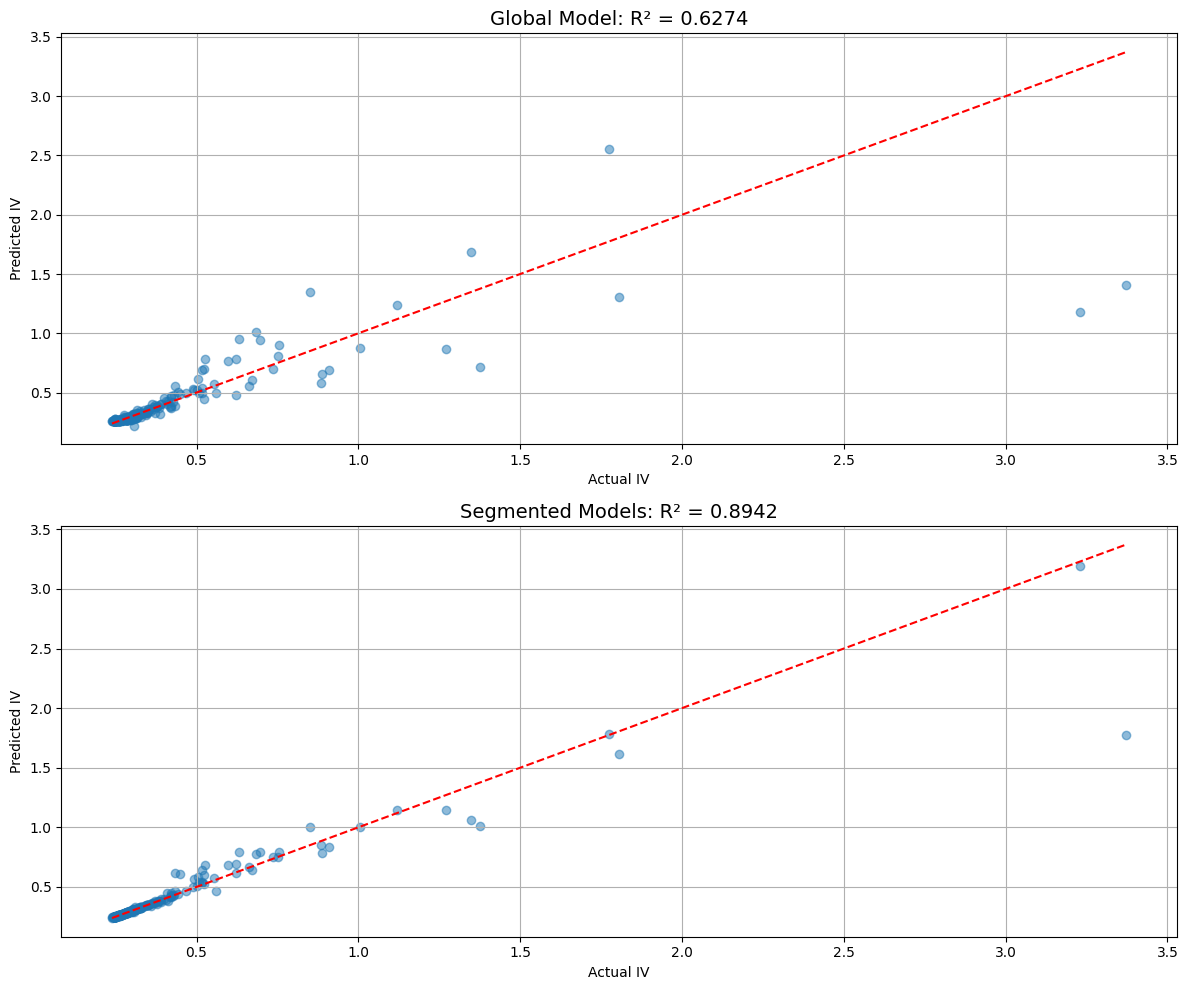

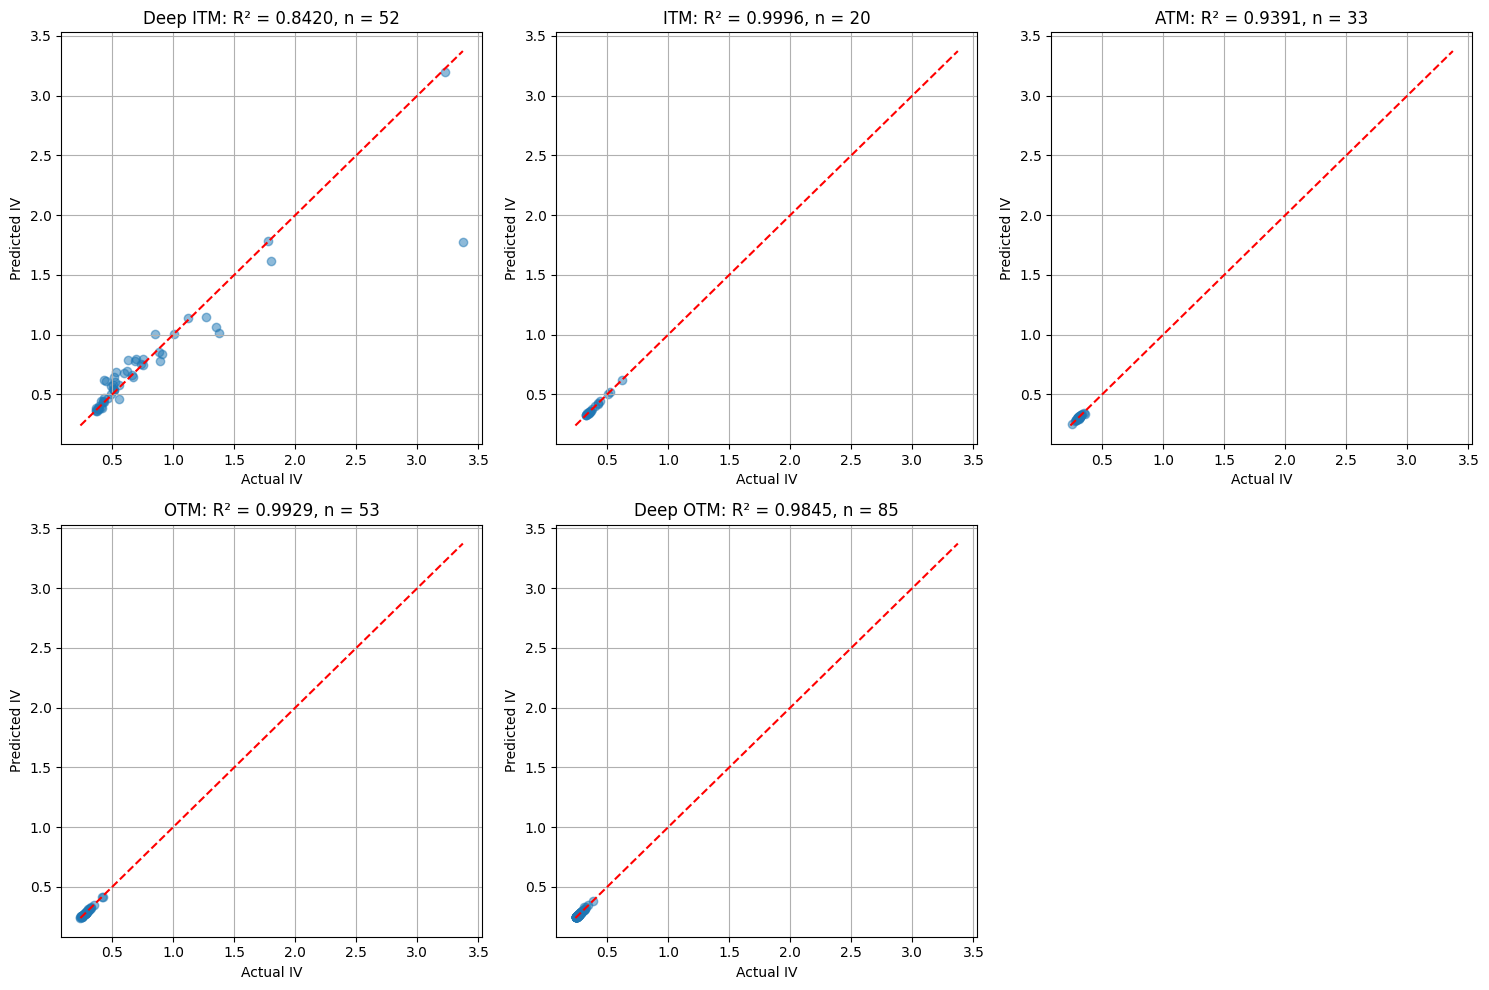

In [23]:
# Visualize the difference between global and segmented predictions
plt.figure(figsize=(12, 10))

# Plot 1: Global model predictions
plt.subplot(2, 1, 1)
plt.scatter(y_test_global, y_pred_global, alpha=0.5)
plt.plot([y_test_global.min(), y_test_global.max()], [y_test_global.min(), y_test_global.max()], 'r--')
plt.title(f"Global Model: R² = {r2_global:.4f}", fontsize=14)
plt.xlabel("Actual IV")
plt.ylabel("Predicted IV")
plt.grid(True)

# Plot 2: Segmented model predictions (where we have them)
if np.any(valid_mask):
    plt.subplot(2, 1, 2)
    plt.scatter(y_test_global[valid_mask], y_pred_segmented[valid_mask], alpha=0.5)
    plt.plot([y_test_global.min(), y_test_global.max()], [y_test_global.min(), y_test_global.max()], 'r--')
    plt.title(f"Segmented Models: R² = {r2_segmented:.4f}", fontsize=14)
    plt.xlabel("Actual IV")
    plt.ylabel("Predicted IV")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize predictions by moneyness segment
plt.figure(figsize=(15, 10))

for i, segment in enumerate(segments):
    segment_mask = segments_test == segment
    if np.any(segment_mask) and segment in segment_models:
        plt.subplot(2, 3, i+1)
        plt.scatter(y_test_global[segment_mask], y_pred_segmented[segment_mask], alpha=0.5)
        plt.plot([y_test_global.min(), y_test_global.max()], [y_test_global.min(), y_test_global.max()], 'r--')

        # Calculate metrics for this segment
        r2_seg = r2_score(y_test_global[segment_mask], y_pred_segmented[segment_mask])
        rmse_seg = np.sqrt(mean_squared_error(y_test_global[segment_mask], y_pred_segmented[segment_mask]))

        plt.title(f"{segment}: R² = {r2_seg:.4f}, n = {sum(segment_mask)}")
        plt.xlabel("Actual IV")
        plt.ylabel("Predicted IV")
        plt.grid(True)

plt.tight_layout()
plt.show()

## **Section 7: Final Hyperparameter Turning**

In [24]:
from sklearn.model_selection import KFold
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [25]:
# Define parameter space for Gradient Boosting
param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.5, 1.0),
    'max_features': Categorical(['sqrt', 'log2', None])
}

In [26]:
# Function to tune a model for a specific segment
def tune_segment_model(segment_name, X_data, y_data):
    segment_mask = df_iv_model['moneyness_segment'] == segment_name
    X_segment = X_data[segment_mask]
    y_segment = y_data[segment_mask]

    if len(X_segment) < 50:
        print(f"Skipping {segment_name} segment as it only has {len(X_segment)} samples")
        return None

    print(f"Tuning model for {segment_name} segment with {len(X_segment)} samples...")

    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create and run Bayesian search
    bayes_search = BayesSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_space,
        n_iter=30,  # Number of parameter settings sampled
        cv=cv,
        n_jobs=-1,  # Use all cores
        scoring='r2',
        verbose=1,
        random_state=42
    )

    scaler = StandardScaler()
    X_segment_scaled = scaler.fit_transform(X_segment)

    bayes_search.fit(X_segment_scaled, y_segment)

    print(f"Best parameters for {segment_name}: {bayes_search.best_params_}")
    print(f"Best CV score for {segment_name}: {bayes_search.best_score_:.4f}")

    # Create optimized model with best parameters
    best_params = bayes_search.best_params_
    best_model = GradientBoostingRegressor(random_state=42, **best_params)

    # Train on entire segment data
    best_model.fit(X_segment_scaled, y_segment)

    return best_model, scaler, best_params

In [27]:
# Tune models for each segment
tuned_segment_models = {}
tuned_segment_scalers = {}
tuned_segment_params = {}

print("\nPerforming hyperparameter tuning for each segment:")
for segment in segments:
    result = tune_segment_model(segment, X_transformed, y)
    if result is not None:
        tuned_segment_models[segment] = result[0]
        tuned_segment_scalers[segment] = result[1]
        tuned_segment_params[segment] = result[2]

# Evaluate tuned models on a holdout set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_transformed, y, test_size=0.2, random_state=99  # Different random state for final evaluation
)



Performing hyperparameter tuning for each segment:
Tuning model for Deep ITM segment with 299 samples...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5

In [28]:
# Function to predict using tuned segmented models
def predict_with_tuned_segments(X_new, segment_column):
    predictions = np.zeros(len(X_new))

    for segment, model in tuned_segment_models.items():
        segment_mask = segment_column == segment
        if np.any(segment_mask):
            scaler = tuned_segment_scalers[segment]
            X_segment = X_new[segment_mask]
            X_segment_scaled = scaler.transform(X_segment)
            predictions[segment_mask] = model.predict(X_segment_scaled)

    return predictions

# Get segments for test data
segments_test_final = df_iv_model.loc[y_test_final.index, 'moneyness_segment']
y_pred_segmented_tuned = predict_with_tuned_segments(X_test_final, segments_test_final)

# Calculate metrics
valid_mask = y_pred_segmented_tuned != 0
if np.any(valid_mask):
    r2_segmented_tuned = r2_score(y_test_final[valid_mask], y_pred_segmented_tuned[valid_mask])
    rmse_segmented_tuned = np.sqrt(mean_squared_error(y_test_final[valid_mask], y_pred_segmented_tuned[valid_mask]))

    print("\nTuned Segmented Models Performance:")
    print(f"R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")

    # Compare with previous results
    print("\nPerformance Improvement:")
    print(f"Previous segmented models: R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")
    print(f"Tuned segmented models:    R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")


Tuned Segmented Models Performance:
R² = 0.9845, RMSE = 0.0217

Performance Improvement:
Previous segmented models: R² = 0.8942, RMSE = 0.1120
Tuned segmented models:    R² = 0.9845, RMSE = 0.0217


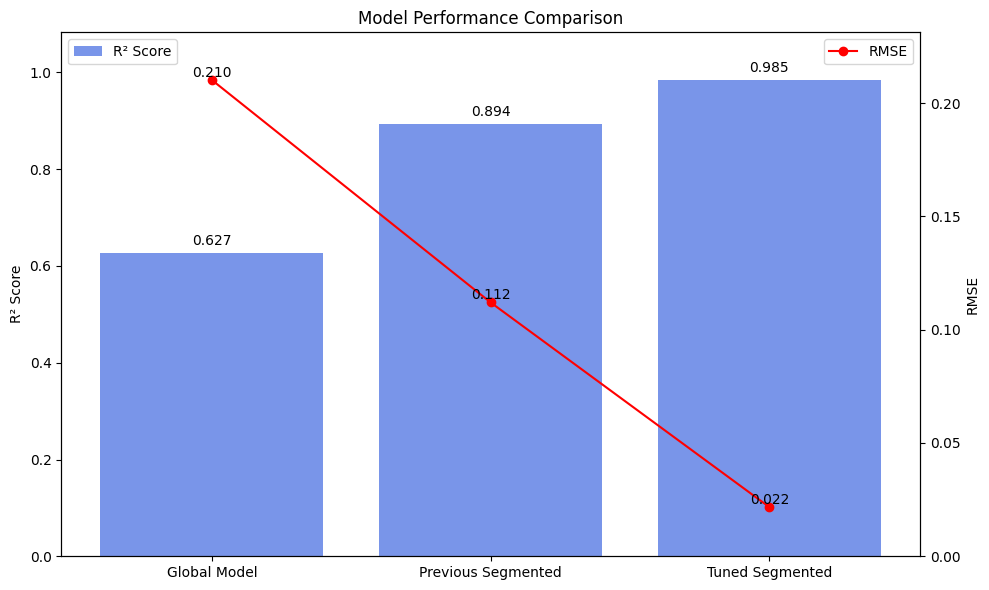

In [29]:
# Data for the chart
model_names = ['Global Model', 'Previous Segmented', 'Tuned Segmented']
r2_scores = [r2_global, r2_segmented, r2_segmented_tuned]
rmse_scores = [rmse_global, rmse_segmented, rmse_segmented_tuned]

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create bars with R² scores
bars = ax1.bar(model_names, r2_scores, color='royalblue', alpha=0.7, label='R² Score')

# Add values on bars
for bar, r2 in zip(bars, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{r2:.3f}', ha='center', va='bottom')

# Set up primary y-axis (R²)
ax1.set_ylabel('R² Score')
ax1.set_ylim(0, max(r2_scores) * 1.1)  # Add 10% margin at top

# Create secondary y-axis for RMSE
ax2 = ax1.twinx()
ax2.plot(model_names, rmse_scores, 'o-', color='red', label='RMSE')

# Add RMSE values
for i, rmse in enumerate(rmse_scores):
    ax2.text(i, rmse, f'{rmse:.3f}', ha='center', va='bottom')

# Set up secondary y-axis (RMSE)
ax2.set_ylabel('RMSE')
ax2.set_ylim(0, max(rmse_scores) * 1.1)  # Add 10% margin at top

# Add title and legends
plt.title('Model Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

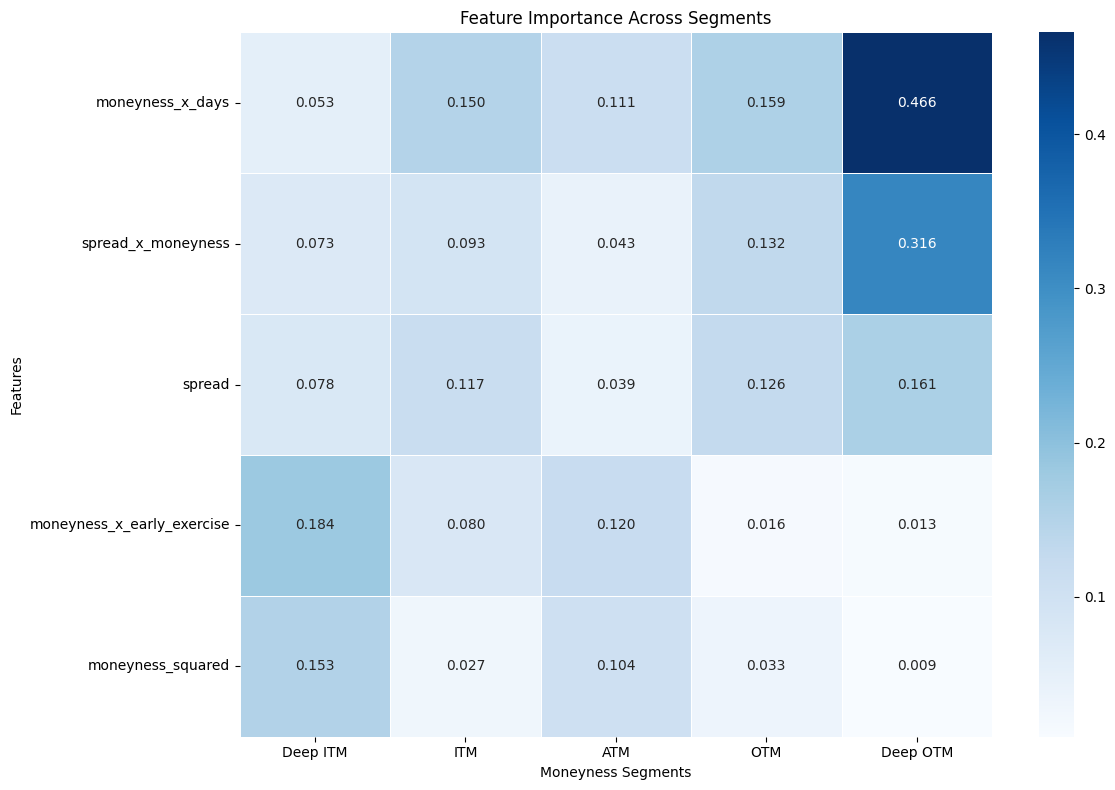

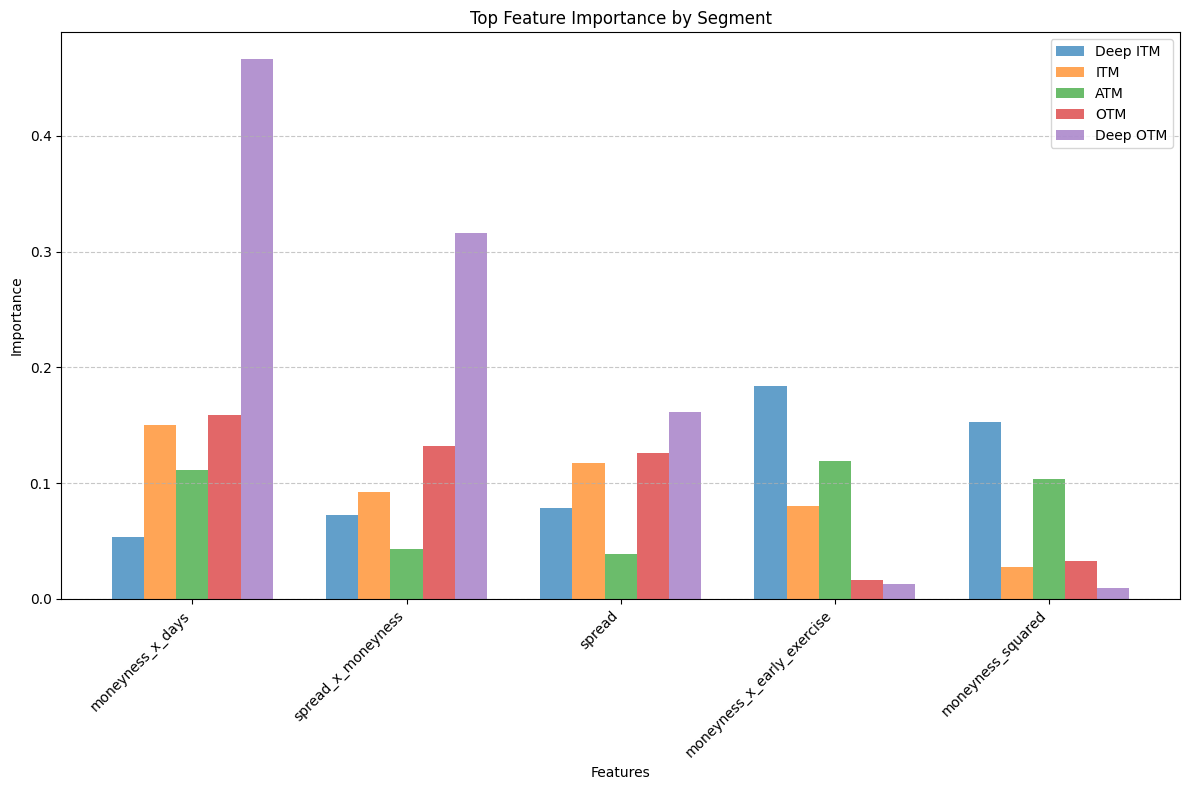

In [30]:
# Simple visualization of feature importance across segments
plt.figure(figsize=(12, 8))

# Get feature importance for each segment
segment_importances = {}

for segment, model in tuned_segment_models.items():
    if hasattr(model, 'feature_importances_'):
        segment_importances[segment] = pd.Series(
            model.feature_importances_,
            index=X_transformed.columns
        )

# Select top 5 features across all segments
all_importances = pd.concat(segment_importances.values(), axis=1)
all_importances.columns = segment_importances.keys()
top_features = all_importances.mean(axis=1).nlargest(5).index

# Create heatmap for top features
heatmap_data = all_importances.loc[top_features]

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Feature Importance Across Segments')
plt.ylabel('Features')
plt.xlabel('Moneyness Segments')
plt.tight_layout()
plt.show()

# Alternative: bar chart for easier comparison
plt.figure(figsize=(12, 8))

# Plot each segment as grouped bars
bar_width = 0.15
positions = np.arange(len(top_features))
segments = list(segment_importances.keys())

for i, segment in enumerate(segments):
    importance_values = segment_importances[segment].loc[top_features].values
    offset = i - len(segments)/2 + 0.5
    plt.bar(positions + bar_width * offset, importance_values,
            width=bar_width, label=segment, alpha=0.7)

plt.xticks(positions, top_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top Feature Importance by Segment')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Section 8: Final Summary and Conclusions**

In [33]:
print("\n==========================================================")
print("Summary of Implied Volatility Prediction Results")
print("==========================================================")
print(f"Initial best model: {best_model_name} with R² Score: {results_df.loc[best_model_name, 'R2 Score']:.4f}")
print(f"Global model with enhanced features: R² = {r2_global:.4f}, RMSE = {rmse_global:.4f}")
print(f"Segmented model with enhanced features: R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")
print(f"Tuned segmented model: R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")
print("\nPerformance improvement from global to tuned segmented: {:.1f}%".format((r2_segmented_tuned - r2_global) / r2_global * 100))

# Get top features for implied volatility (may need to adapt based on your feature importance analysis)
# Assuming you have a similar 'all_importances' DataFrame for IV as for spread:
top_features_iv = all_importances.mean(axis=1).nlargest(5).index

print("\nTop 5 features for predicting implied volatility:")
for feature in top_features_iv:
    print(f"- {feature}")

print("\nModel performance by segment:")
for segment in segments:
    segment_mask = segments_test_final == segment
    if np.any(segment_mask) and segment in tuned_segment_models:
        r2_seg = r2_score(y_test_final[segment_mask], y_pred_segmented_tuned[segment_mask])
        print(f"- {segment}: R² = {r2_seg:.4f}, Samples = {sum(segment_mask)}")
# Final summary and conclusions for Implied Volatility
print("\n==========================================================")
print("Summary of Implied Volatility Prediction Results")
print("==========================================================")
print(f"Initial best model: {best_model_name} with R² Score: {results_df.loc[best_model_name, 'R2 Score']:.4f}")
print(f"Global model with enhanced features: R² = {r2_global:.4f}, RMSE = {rmse_global:.4f}")
print(f"Segmented model with enhanced features: R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")
print(f"Tuned segmented model: R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")
print("\nPerformance improvement from global to tuned segmented: {:.1f}%".format((r2_segmented_tuned - r2_global) / r2_global * 100))

# Get top features for implied volatility (may need to adapt based on your feature importance analysis)
# Assuming you have a similar 'all_importances' DataFrame for IV as for spread:
top_features_iv = all_importances.mean(axis=1).nlargest(5).index

print("\nTop 5 features for predicting implied volatility:")
for feature in top_features_iv:
    print(f"- {feature}")

print("\nModel performance by segment:")
for segment in segments:
    segment_mask = segments_test_final == segment
    if np.any(segment_mask) and segment in tuned_segment_models:
        r2_seg = r2_score(y_test_final[segment_mask], y_pred_segmented_tuned[segment_mask])
        print(f"- {segment}: R² = {r2_seg:.4f}, Samples = {sum(segment_mask)}")

print("\nConclusion: The segmented modeling approach demonstrates its")
print("")


Summary of Implied Volatility Prediction Results
Initial best model: Gradient Boosting with R² Score: 0.7580
Global model with enhanced features: R² = 0.6274, RMSE = 0.2102
Segmented model with enhanced features: R² = 0.8942, RMSE = 0.1120
Tuned segmented model: R² = 0.9845, RMSE = 0.0217

Performance improvement from global to tuned segmented: 56.9%

Top 5 features for predicting implied volatility:
- moneyness_x_days
- spread_x_moneyness
- spread
- moneyness_x_early_exercise
- moneyness_squared

Model performance by segment:
- Deep ITM: R² = 0.9601, Samples = 63
- ITM: R² = 0.9992, Samples = 24
- ATM: R² = 0.9969, Samples = 27
- OTM: R² = 0.9993, Samples = 52
- Deep OTM: R² = 0.9992, Samples = 77

Summary of Implied Volatility Prediction Results
Initial best model: Gradient Boosting with R² Score: 0.7580
Global model with enhanced features: R² = 0.6274, RMSE = 0.2102
Segmented model with enhanced features: R² = 0.8942, RMSE = 0.1120
Tuned segmented model: R² = 0.9845, RMSE = 0.0217


# **Estimating Bid-Ask Spreads Using Market Data (MSFT)**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tcn
from tcn import TCN
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## **Section 1: Data Loading and preprocessing**

In [35]:
# Load data
df = pd.read_csv("/content/Microsoft Options.csv")

In [36]:
# Basic feature engineering
df['Days to Expiration'] = pd.to_numeric(df['Days to Expiration'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
df['openInterest'] = pd.to_numeric(df['openInterest'], errors='coerce')
df['impliedVolatility'] = pd.to_numeric(df['impliedVolatility'], errors='coerce')
df['spread'] = (df['ask'] - df['bid']) / ((df['ask'] + df['bid']) / 2)
df['moneyness'] = df['Stock Price'] / df['strike']
df['inTheMoney_dummy'] = df['inTheMoney'].astype(int)

# American option-specific features
df['dividend_impact'] = df['Dividend Yield'] * df['Days to Expiration']/365
df['margin_req'] = np.where(
    df['Type'] == 'Call',
    np.where(
        df['inTheMoney'],
        df['Stock Price'] * 0.20,  # 20% for ITM calls
        df['Stock Price'] * 0.10   # 10% for OTM calls
    ),
    np.where(
        df['inTheMoney'],
        (df['strike'] - df['Stock Price']) + (df['Stock Price'] * 0.20),  # For ITM puts
        df['strike'] * 0.10  # 10% of strike for OTM puts
    )
)
df['early_exercise_premium'] = np.where(
    df['Dividend Yield'] > 0,  # If there are dividends
    (df['Dividend Yield'] * df['Stock Price'] *
     np.exp(-df['Treasury Rate'] * df['Days to Expiration']/365)),  # PV of dividends
    0  # No early exercise premium for no dividends
)

In [37]:
# Filter dataset for modeling spread
df_spread_model = df[
    (df['Type'] == 'Call') &
    df[['impliedVolatility', 'spread', 'moneyness', 'Days to Expiration', 'volume', 'openInterest']].notnull().all(axis=1)
].copy()
df_spread_model = df_spread_model[(df_spread_model['spread'] > 0) & (df_spread_model['spread'] < 2)]

In [38]:
# Define features for spread prediction
# Note: we use 'impliedVolatility' as a feature since we're now predicting spread
basic_features = ['impliedVolatility', 'moneyness', 'Days to Expiration', 'volume', 'openInterest', 'inTheMoney_dummy']
enhanced_features = basic_features + ['dividend_impact', 'margin_req', 'early_exercise_premium']
target = 'spread'  # Now predicting spread instead of impliedVolatility

X = df_spread_model[enhanced_features]
y = df_spread_model[target]

print("Dataset shape:", df_spread_model.shape)
print("Features:", enhanced_features)

Dataset shape: (1214, 27)
Features: ['impliedVolatility', 'moneyness', 'Days to Expiration', 'volume', 'openInterest', 'inTheMoney_dummy', 'dividend_impact', 'margin_req', 'early_exercise_premium']


## **Section 2: Exploratory Data Analysis**

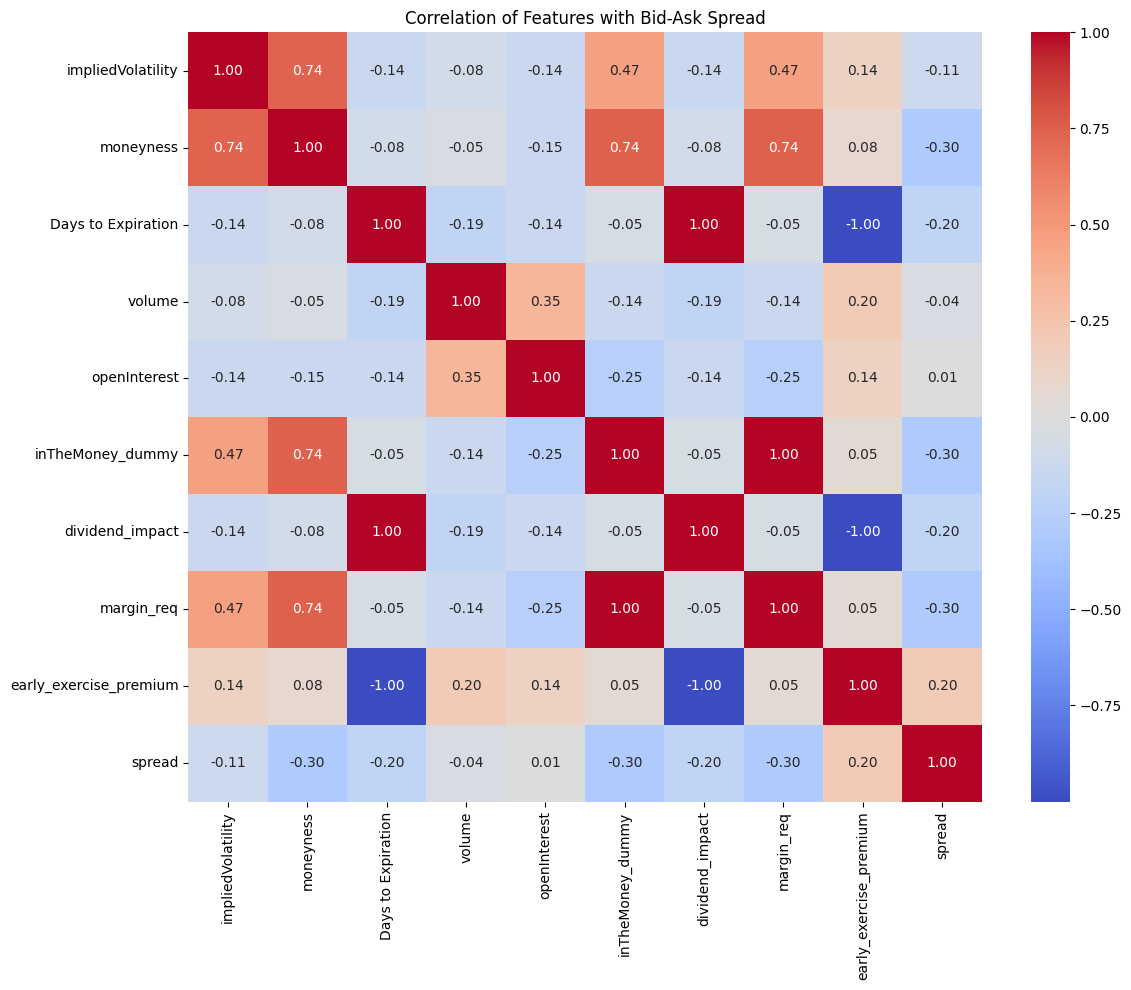

In [39]:
# Key visualizations for bid-ask spread

# 1. Correlation heatmap
plt.figure(figsize=(12, 10))
correlation = df_spread_model[enhanced_features + [target]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Bid-Ask Spread")
plt.tight_layout()
plt.show()

<ipython-input-40-5d4da855e484>:3: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




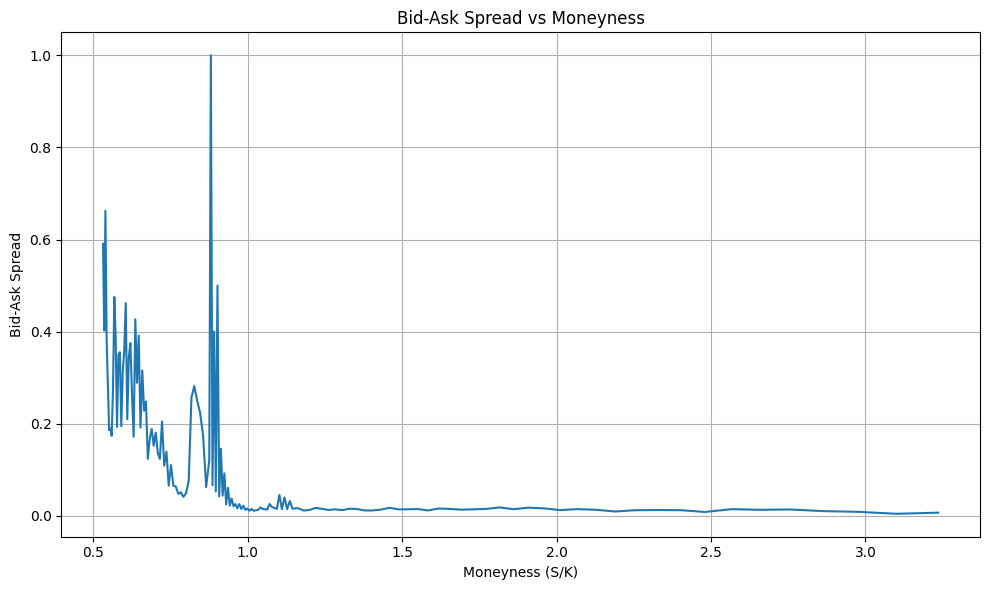

In [40]:
# 2. Spread vs moneyness
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_spread_model, x='moneyness', y='spread', ci=None)
plt.title('Bid-Ask Spread vs Moneyness')
plt.xlabel('Moneyness (S/K)')
plt.ylabel('Bid-Ask Spread')
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# 3. 3D visualization of spread surface
fig_3d = px.scatter_3d(
    df_spread_model.sample(min(1000, len(df_spread_model))),  # Sample to prevent overplotting
    x='moneyness',
    y='Days to Expiration',
    z='spread',
    color='spread',
    color_continuous_scale='Viridis',
    title='3D Visualization of Bid-Ask Spread Surface',
    labels={
        'moneyness': 'Moneyness (S/K)',
        'Days to Expiration': 'Days to Expiration',
        'spread': 'Bid-Ask Spread'
    }
)
fig_3d.update_layout(scene=dict(
    xaxis_title='Moneyness',
    yaxis_title='Days to Expiration',
    zaxis_title='Spread'
))
fig_3d.show()

## **Section 3: Model Training and Evaluation**

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [43]:
# Define traditional ML models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(),
    "Lasso": Lasso(alpha=0.01),
    "Ridge": Ridge(alpha=0.01),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate traditional ML models
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r2}

Training Linear Regression...
Training Random Forest...
Training SVR...
Training Lasso...
Training Ridge...
Training Gradient Boosting...
Training XGBoost...
Training KNN...
Training Decision Tree...
Training MLP...


In [44]:
# Neural Network with early stopping
print("Training Neural Network (Keras)...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    verbose=0,
    validation_split=0.2,
    callbacks=[early_stop]
)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)
results["Neural Network (Keras)"] = {"MAE": mae_nn, "MSE": mse_nn, "RMSE": rmse_nn, "R2 Score": r2_nn}

Training Neural Network (Keras)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [45]:
# LSTM model
print("Training LSTM...")
# Reshape input for sequence models
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(
    X_train_seq, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

y_pred_lstm = lstm_model.predict(X_test_seq).flatten()
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
results["LSTM"] = {"MAE": mae_lstm, "MSE": mse_lstm, "RMSE": rmse_lstm, "R2 Score": r2_lstm}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Training LSTM...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [46]:
# TCN model
print("Training TCN...")
try:
    tcn_model = Sequential()
    tcn_model.add(TCN(nb_filters=64, kernel_size=2, dilations=[1, 2, 4, 8],
                     return_sequences=False, input_shape=(1, X_train_scaled.shape[1])))
    tcn_model.add(Dense(1))
    tcn_model.compile(optimizer='adam', loss='mse')

    tcn_model.fit(
        X_train_seq, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_tcn = tcn_model.predict(X_test_seq).flatten()
    mae_tcn = mean_absolute_error(y_test, y_pred_tcn)
    mse_tcn = mean_squared_error(y_test, y_pred_tcn)
    rmse_tcn = np.sqrt(mse_tcn)
    r2_tcn = r2_score(y_test, y_pred_tcn)
    results["TCN"] = {"MAE": mae_tcn, "MSE": mse_tcn, "RMSE": rmse_tcn, "R2 Score": r2_tcn}
except Exception as e:
    print(f"Error training TCN: {e}")
    results["TCN"] = {"MAE": np.nan, "MSE": np.nan, "RMSE": np.nan, "R2 Score": np.nan}

Training TCN...


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


## **Section 4: Results Analysis**

In [47]:
# Convert results to DataFrame and rank
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("R2 Score", ascending=False)
print("\nModel Comparison (Ranked by R2 Score):")
print(results_df)

# Find the best model
best_model_name = results_df.index[0]
print(f"\nBest model: {best_model_name} with R² Score: {results_df.loc[best_model_name, 'R2 Score']:.4f}")


Model Comparison (Ranked by R2 Score):
                             MAE       MSE      RMSE  R2 Score
Random Forest           0.024816  0.004768  0.069047  0.932592
XGBoost                 0.030878  0.007383  0.085927  0.895607
Decision Tree           0.034070  0.010631  0.103108  0.849686
Gradient Boosting       0.033437  0.010658  0.103238  0.849306
KNN                     0.039228  0.012173  0.110330  0.827892
Neural Network (Keras)  0.047118  0.013258  0.115143  0.812549
TCN                     0.053741  0.015275  0.123590  0.784034
MLP                     0.056253  0.017695  0.133021  0.749817
LSTM                    0.052635  0.018645  0.136546  0.736384
SVR                     0.084178  0.026955  0.164179  0.618890
Linear Regression       0.132480  0.056796  0.238320  0.196961
Ridge                   0.132423  0.056820  0.238369  0.196632
Lasso                   0.128055  0.060300  0.245561  0.147421

Best model: Random Forest with R² Score: 0.9326


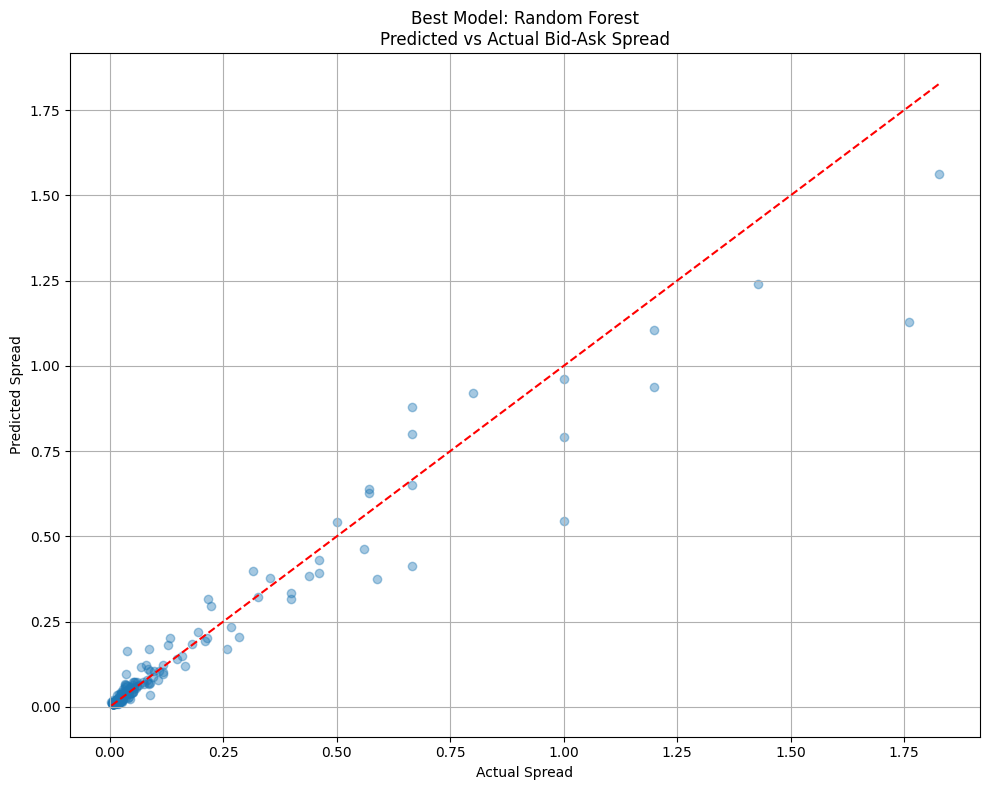

In [48]:
# Plot predicted vs actual for the best model
plt.figure(figsize=(10, 8))
if best_model_name == "Neural Network (Keras)":
    best_pred = y_pred_nn
elif best_model_name == "LSTM":
    best_pred = y_pred_lstm
elif best_model_name == "TCN":
    best_pred = y_pred_tcn
else:
    best_pred = models[best_model_name].predict(X_test_scaled)

plt.scatter(y_test, best_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Spread")
plt.ylabel("Predicted Spread")
plt.title(f"Best Model: {best_model_name}\nPredicted vs Actual Bid-Ask Spread")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Section 5: Model Interpretability**

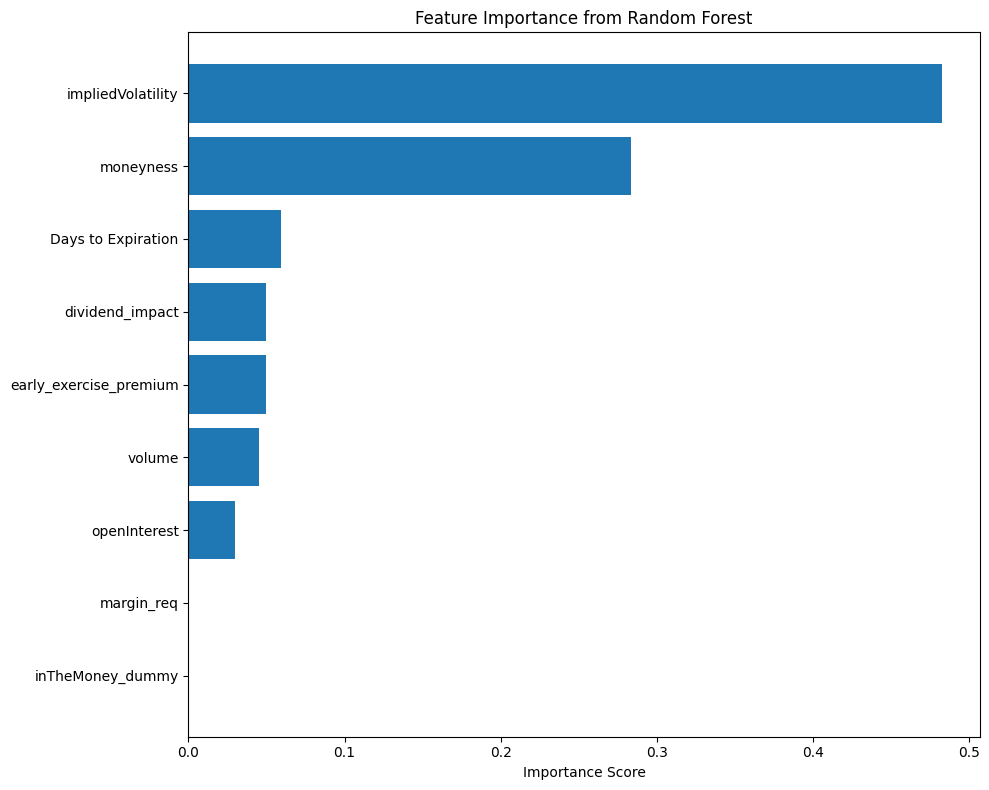

In [49]:
# Feature importance for tree-based models
if best_model_name in ["Random Forest", "XGBoost", "Gradient Boosting", "Decision Tree"]:
    best_model = models[best_model_name]

    # Calculate feature importance
    importances = best_model.feature_importances_
    feature_names = X.columns

    # Sort features by importance
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f"Feature Importance from {best_model_name}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


Generating SHAP values for Random Forest...


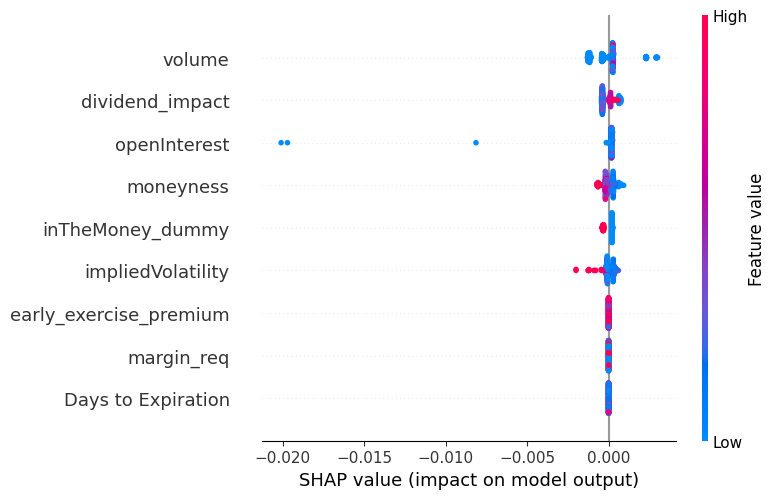

<Figure size 640x480 with 0 Axes>

In [50]:
# SHAP analysis for the best model
print(f"\nGenerating SHAP values for {best_model_name}...")
try:
    # Create explainer
    explainer = shap.Explainer(best_model, X_train)

    # Calculate SHAP values
    shap_values = explainer(X_test)

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in SHAP analysis: {e}")

## **Section 6: Additional Feature Engineering for Model Enhancement**

In [51]:
# Enhanced modeling approach for bid-ask spread

# 1. Create polynomial features for moneyness and transformations
df_spread_model['moneyness_squared'] = df_spread_model['moneyness'] ** 2
df_spread_model['moneyness_cubed'] = df_spread_model['moneyness'] ** 3
df_spread_model['log_days_to_expiration'] = np.log1p(df_spread_model['Days to Expiration'])  # log(1+x) to handle zeros
df_spread_model['sqrt_days_to_expiration'] = np.sqrt(df_spread_model['Days to Expiration'])

In [52]:
# 2. Create interaction terms
df_spread_model['moneyness_x_early_exercise'] = df_spread_model['moneyness'] * df_spread_model['early_exercise_premium']
df_spread_model['moneyness_x_days'] = df_spread_model['moneyness'] * df_spread_model['Days to Expiration']
df_spread_model['moneyness_x_iv'] = df_spread_model['moneyness'] * df_spread_model['impliedVolatility']
df_spread_model['iv_x_days'] = df_spread_model['impliedVolatility'] * df_spread_model['Days to Expiration']

In [53]:
# Update the feature list with transformed and interaction features
transformed_features = enhanced_features + [
    'moneyness_squared', 'moneyness_cubed',
    'log_days_to_expiration', 'sqrt_days_to_expiration',
    'moneyness_x_early_exercise', 'moneyness_x_days', 'moneyness_x_iv', 'iv_x_days'
]

print("\nEnhanced feature set:")
print(transformed_features)

# Use the transformed features for modeling
X_transformed = df_spread_model[transformed_features]


Enhanced feature set:
['impliedVolatility', 'moneyness', 'Days to Expiration', 'volume', 'openInterest', 'inTheMoney_dummy', 'dividend_impact', 'margin_req', 'early_exercise_premium', 'moneyness_squared', 'moneyness_cubed', 'log_days_to_expiration', 'sqrt_days_to_expiration', 'moneyness_x_early_exercise', 'moneyness_x_days', 'moneyness_x_iv', 'iv_x_days']


In [54]:
# 3. Segmented Modeling (Defining segments based on moneyness)
def classify_moneyness(x):
    if x < 0.8:
        return 'Deep OTM'
    elif x < 0.95:
        return 'OTM'
    elif x < 1.05:
        return 'ATM'
    elif x < 1.2:
        return 'ITM'
    else:
        return 'Deep ITM'

df_spread_model['moneyness_segment'] = df_spread_model['moneyness'].apply(classify_moneyness)

# Function to train and evaluate model on a specific segment
def train_segment_model(segment_name, X_data, y_data):
    # Filter data for the segment
    segment_mask = df_spread_model['moneyness_segment'] == segment_name
    X_segment = X_data[segment_mask]
    y_segment = y_data[segment_mask]

    # Skip if not enough data
    if len(X_segment) < 50:
        print(f"Skipping {segment_name} segment as it only has {len(X_segment)} samples")
        return None, None

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_segment, y_segment, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Gradient Boosting (best performing model from previous analysis)
    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"{segment_name} segment: R² = {r2:.4f}, RMSE = {rmse:.4f}, Samples = {len(X_segment)}")

    # Feature importance for this segment
    if hasattr(model, 'feature_importances_'):
        segment_importances = pd.DataFrame({
            'Feature': X_segment.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False).head(5)

        print(f"Top 5 features for {segment_name} segment:")
        print(segment_importances)

    return model, scaler

In [55]:
# Train and evaluate models on different segments
segment_models = {}
segment_scalers = {}
segments = df_spread_model['moneyness_segment'].unique()

print("\nTraining segmented models for spread prediction:")
for segment in segments:
    print(f"\nProcessing {segment} segment...")
    model, scaler = train_segment_model(segment, X_transformed, y)
    if model is not None:
        segment_models[segment] = model
        segment_scalers[segment] = scaler

# Function to predict using the appropriate segment model
def predict_with_segments(X_new, segment_column):
    predictions = np.zeros(len(X_new))

    for segment, model in segment_models.items():
        segment_mask = segment_column == segment
        if np.any(segment_mask) and model is not None:
            scaler = segment_scalers[segment]
            X_segment = X_new[segment_mask]
            X_segment_scaled = scaler.transform(X_segment)
            predictions[segment_mask] = model.predict(X_segment_scaled)

    return predictions


Training segmented models for spread prediction:

Processing Deep ITM segment...
Deep ITM segment: R² = 0.5670, RMSE = 0.0037, Samples = 299
Top 5 features for Deep ITM segment:
                       Feature  Importance
16                   iv_x_days    0.354500
14            moneyness_x_days    0.122903
0            impliedVolatility    0.119372
13  moneyness_x_early_exercise    0.103391
15              moneyness_x_iv    0.079869

Processing ITM segment...
ITM segment: R² = 0.7125, RMSE = 0.0047, Samples = 127
Top 5 features for ITM segment:
              Feature  Importance
0   impliedVolatility    0.366566
14   moneyness_x_days    0.227901
16          iv_x_days    0.114983
4        openInterest    0.114960
15     moneyness_x_iv    0.056396

Processing ATM segment...
ATM segment: R² = 0.6572, RMSE = 0.0047, Samples = 156
Top 5 features for ATM segment:
                       Feature  Importance
13  moneyness_x_early_exercise    0.290106
12     sqrt_days_to_expiration    0.138430
8 

In [56]:
# Now let's compare the combined segmented approach with the global model

# First train a global model using the same transformed features
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42
)

scaler_global = StandardScaler()
X_train_global_scaled = scaler_global.fit_transform(X_train_global)
X_test_global_scaled = scaler_global.transform(X_test_global)

global_model = GradientBoostingRegressor(random_state=42)
global_model.fit(X_train_global_scaled, y_train_global)
y_pred_global = global_model.predict(X_test_global_scaled)

# Test segment prediction
segments_test = df_spread_model.loc[y_test_global.index, 'moneyness_segment']
y_pred_segmented = predict_with_segments(X_test_global, segments_test)

In [57]:
# Compare results
r2_global = r2_score(y_test_global, y_pred_global)
rmse_global = np.sqrt(mean_squared_error(y_test_global, y_pred_global))

# Calculate metrics for segmented predictions (only where predictions were made)
valid_mask = y_pred_segmented != 0
if np.any(valid_mask):
    r2_segmented = r2_score(y_test_global[valid_mask], y_pred_segmented[valid_mask])
    rmse_segmented = np.sqrt(mean_squared_error(y_test_global[valid_mask], y_pred_segmented[valid_mask]))
else:
    r2_segmented = np.nan
    rmse_segmented = np.nan

print("\nModel Performance Comparison:")
print(f"Global model:     R² = {r2_global:.4f}, RMSE = {rmse_global:.4f}")
print(f"Segmented models: R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")


Model Performance Comparison:
Global model:     R² = 0.8812, RMSE = 0.0917
Segmented models: R² = 0.9384, RMSE = 0.0660


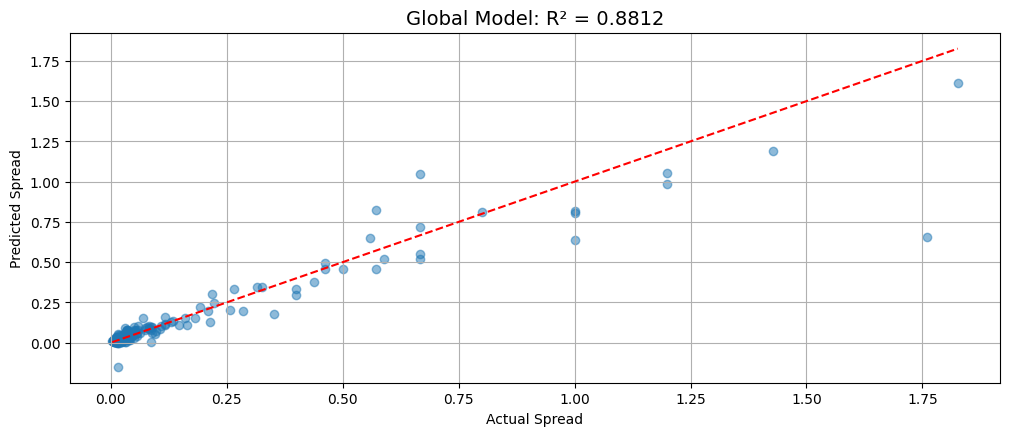

In [58]:
# Visualize the difference between global and segmented predictions
plt.figure(figsize=(12, 10))

# Plot 1: Global model predictions
plt.subplot(2, 1, 1)
plt.scatter(y_test_global, y_pred_global, alpha=0.5)
plt.plot([y_test_global.min(), y_test_global.max()], [y_test_global.min(), y_test_global.max()], 'r--')
plt.title(f"Global Model: R² = {r2_global:.4f}", fontsize=14)
plt.xlabel("Actual Spread")
plt.ylabel("Predicted Spread")
plt.grid(True)

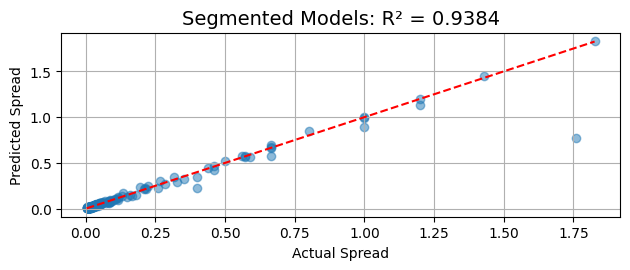

In [59]:
# Plot 2: Segmented model predictions (where we have them)
if np.any(valid_mask):
    plt.subplot(2, 1, 2)
    plt.scatter(y_test_global[valid_mask], y_pred_segmented[valid_mask], alpha=0.5)
    plt.plot([y_test_global.min(), y_test_global.max()], [y_test_global.min(), y_test_global.max()], 'r--')
    plt.title(f"Segmented Models: R² = {r2_segmented:.4f}", fontsize=14)
    plt.xlabel("Actual Spread")
    plt.ylabel("Predicted Spread")
    plt.grid(True)

plt.tight_layout()
plt.show()

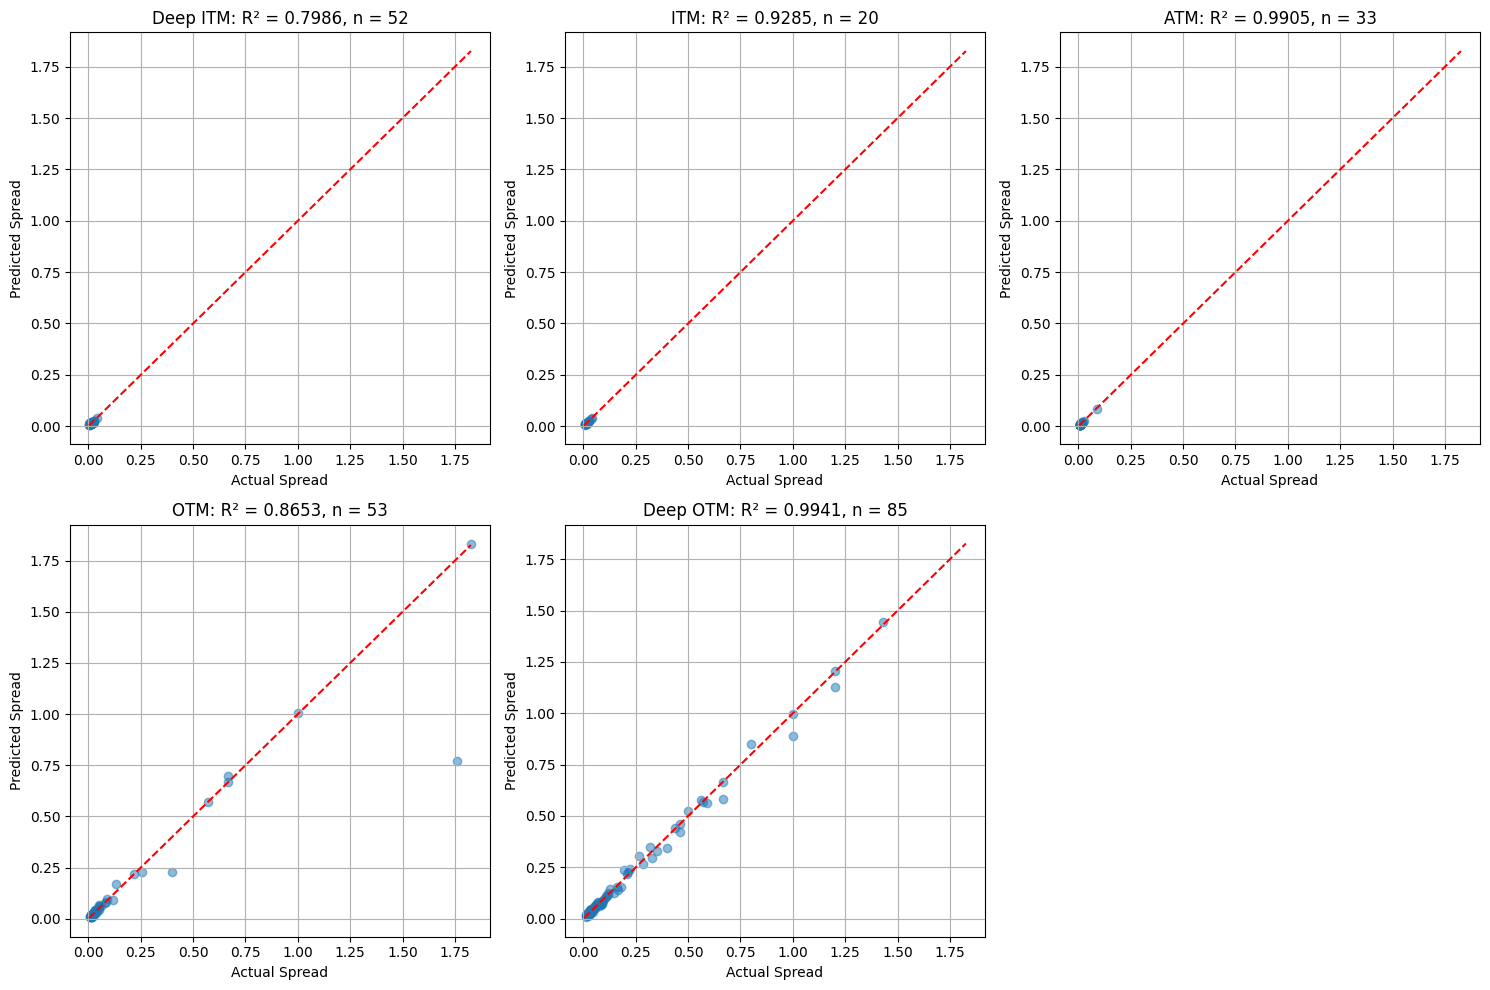

In [60]:
# Visualize predictions by moneyness segment
plt.figure(figsize=(15, 10))

for i, segment in enumerate(segments):
    segment_mask = segments_test == segment
    if np.any(segment_mask) and segment in segment_models:
        plt.subplot(2, 3, i+1)
        plt.scatter(y_test_global[segment_mask], y_pred_segmented[segment_mask], alpha=0.5)
        plt.plot([y_test_global.min(), y_test_global.max()], [y_test_global.min(), y_test_global.max()], 'r--')

        # Calculate metrics for this segment
        r2_seg = r2_score(y_test_global[segment_mask], y_pred_segmented[segment_mask])
        rmse_seg = np.sqrt(mean_squared_error(y_test_global[segment_mask], y_pred_segmented[segment_mask]))

        plt.title(f"{segment}: R² = {r2_seg:.4f}, n = {sum(segment_mask)}")
        plt.xlabel("Actual Spread")
        plt.ylabel("Predicted Spread")
        plt.grid(True)

plt.tight_layout()
plt.show()

## **Section 7: Final Hyperparameter Turning**

In [61]:
# Define parameter space for Gradient Boosting
param_space = {
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'subsample': Real(0.5, 1.0),
    'max_features': Categorical(['sqrt', 'log2', None])
}

# Function to tune a model for a specific segment
def tune_segment_model(segment_name, X_data, y_data):
    segment_mask = df_spread_model['moneyness_segment'] == segment_name
    X_segment = X_data[segment_mask]
    y_segment = y_data[segment_mask]

    if len(X_segment) < 50:
        print(f"Skipping {segment_name} segment as it only has {len(X_segment)} samples")
        return None

    print(f"Tuning model for {segment_name} segment with {len(X_segment)} samples...")

    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Create and run Bayesian search
    bayes_search = BayesSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_space,
        n_iter=20,  # Reduced from 30 to save time
        cv=cv,
        n_jobs=-1,  # Use all cores
        scoring='r2',
        verbose=1,
        random_state=42
    )

    scaler = StandardScaler()
    X_segment_scaled = scaler.fit_transform(X_segment)

    bayes_search.fit(X_segment_scaled, y_segment)

    print(f"Best parameters for {segment_name}: {bayes_search.best_params_}")
    print(f"Best CV score for {segment_name}: {bayes_search.best_score_:.4f}")

    # Create optimized model with best parameters
    best_params = bayes_search.best_params_
    best_model = GradientBoostingRegressor(random_state=42, **best_params)

    # Train on entire segment data
    best_model.fit(X_segment_scaled, y_segment)

    return best_model, scaler, best_params

In [62]:
# Tune models for each segment
tuned_segment_models = {}
tuned_segment_scalers = {}
tuned_segment_params = {}

print("\nPerforming hyperparameter tuning for each segment:")
for segment in segments:
    result = tune_segment_model(segment, X_transformed, y)
    if result is not None:
        tuned_segment_models[segment] = result[0]
        tuned_segment_scalers[segment] = result[1]
        tuned_segment_params[segment] = result[2]

# Evaluate tuned models on a holdout set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_transformed, y, test_size=0.2, random_state=99  # Different random state for final evaluation
)

# Function to predict using tuned segmented models
def predict_with_tuned_segments(X_new, segment_column):
    predictions = np.zeros(len(X_new))

    for segment, model in tuned_segment_models.items():
        segment_mask = segment_column == segment
        if np.any(segment_mask):
            scaler = tuned_segment_scalers[segment]
            X_segment = X_new[segment_mask]
            X_segment_scaled = scaler.transform(X_segment)
            predictions[segment_mask] = model.predict(X_segment_scaled)

    return predictions

# Get segments for test data
segments_test_final = df_spread_model.loc[y_test_final.index, 'moneyness_segment']
y_pred_segmented_tuned = predict_with_tuned_segments(X_test_final, segments_test_final)


Performing hyperparameter tuning for each segment:
Tuning model for Deep ITM segment with 299 samples...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5

In [63]:
# Calculate metrics
valid_mask = y_pred_segmented_tuned != 0
if np.any(valid_mask):
    r2_segmented_tuned = r2_score(y_test_final[valid_mask], y_pred_segmented_tuned[valid_mask])
    rmse_segmented_tuned = np.sqrt(mean_squared_error(y_test_final[valid_mask], y_pred_segmented_tuned[valid_mask]))

    print("\nTuned Segmented Models Performance:")
    print(f"R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")

    # Compare with previous results
    print("\nPerformance Improvement:")
    print(f"Global model:            R² = {r2_global:.4f}, RMSE = {rmse_global:.4f}")
    print(f"Basic segmented models:  R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")
    print(f"Tuned segmented models:  R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")


Tuned Segmented Models Performance:
R² = 0.9967, RMSE = 0.0122

Performance Improvement:
Global model:            R² = 0.8812, RMSE = 0.0917
Basic segmented models:  R² = 0.9384, RMSE = 0.0660
Tuned segmented models:  R² = 0.9967, RMSE = 0.0122


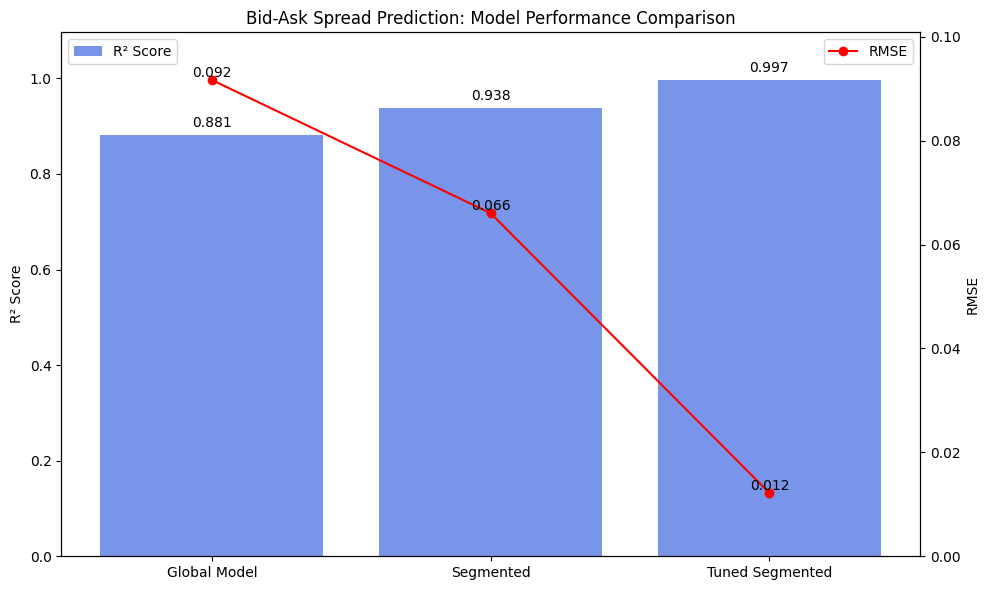

In [64]:
# Data for the chart
model_names = ['Global Model', 'Segmented', 'Tuned Segmented']
r2_scores = [r2_global, r2_segmented, r2_segmented_tuned]
rmse_scores = [rmse_global, rmse_segmented, rmse_segmented_tuned]

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create bars with R² scores
bars = ax1.bar(model_names, r2_scores, color='royalblue', alpha=0.7, label='R² Score')

# Add values on bars
for bar, r2 in zip(bars, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{r2:.3f}', ha='center', va='bottom')

# Set up primary y-axis (R²)
ax1.set_ylabel('R² Score')
ax1.set_ylim(0, max(r2_scores) * 1.1)  # Add 10% margin at top

# Create secondary y-axis for RMSE
ax2 = ax1.twinx()
ax2.plot(model_names, rmse_scores, 'o-', color='red', label='RMSE')

# Add RMSE values
for i, rmse in enumerate(rmse_scores):
    ax2.text(i, rmse, f'{rmse:.3f}', ha='center', va='bottom')

# Set up secondary y-axis (RMSE)
ax2.set_ylabel('RMSE')
ax2.set_ylim(0, max(rmse_scores) * 1.1)  # Add 10% margin at top

# Add title and legends
plt.title('Bid-Ask Spread Prediction: Model Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

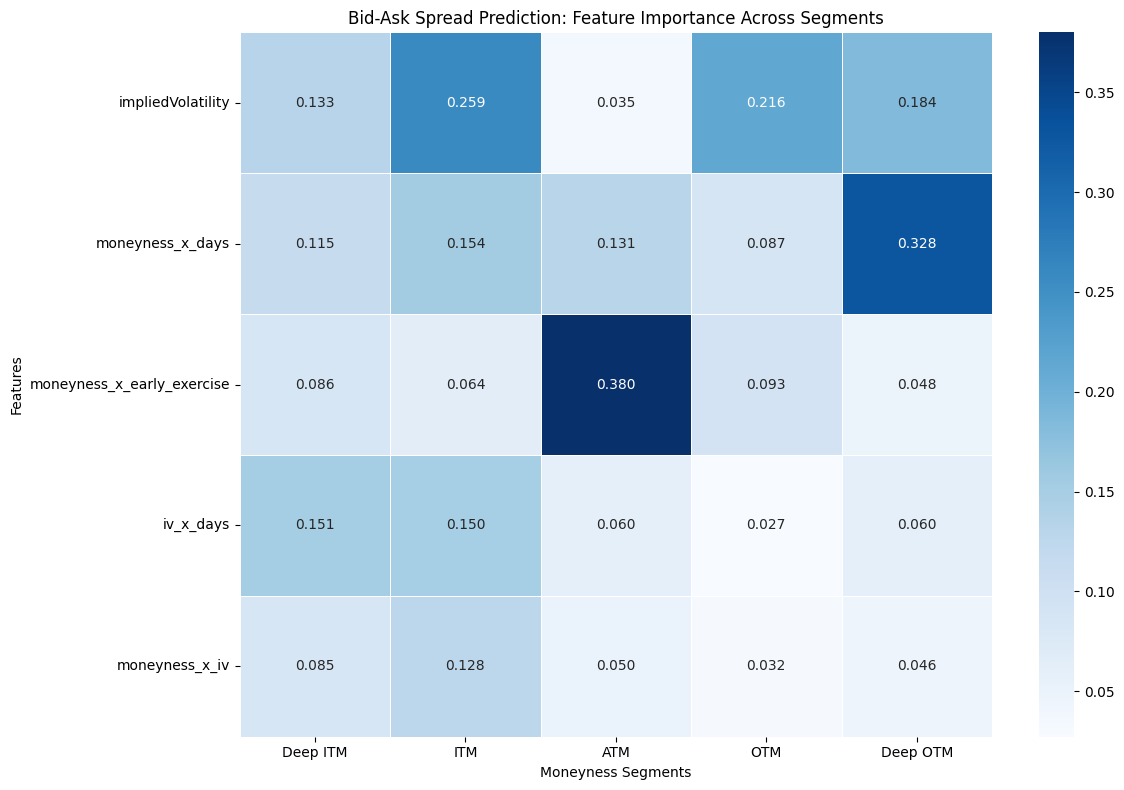

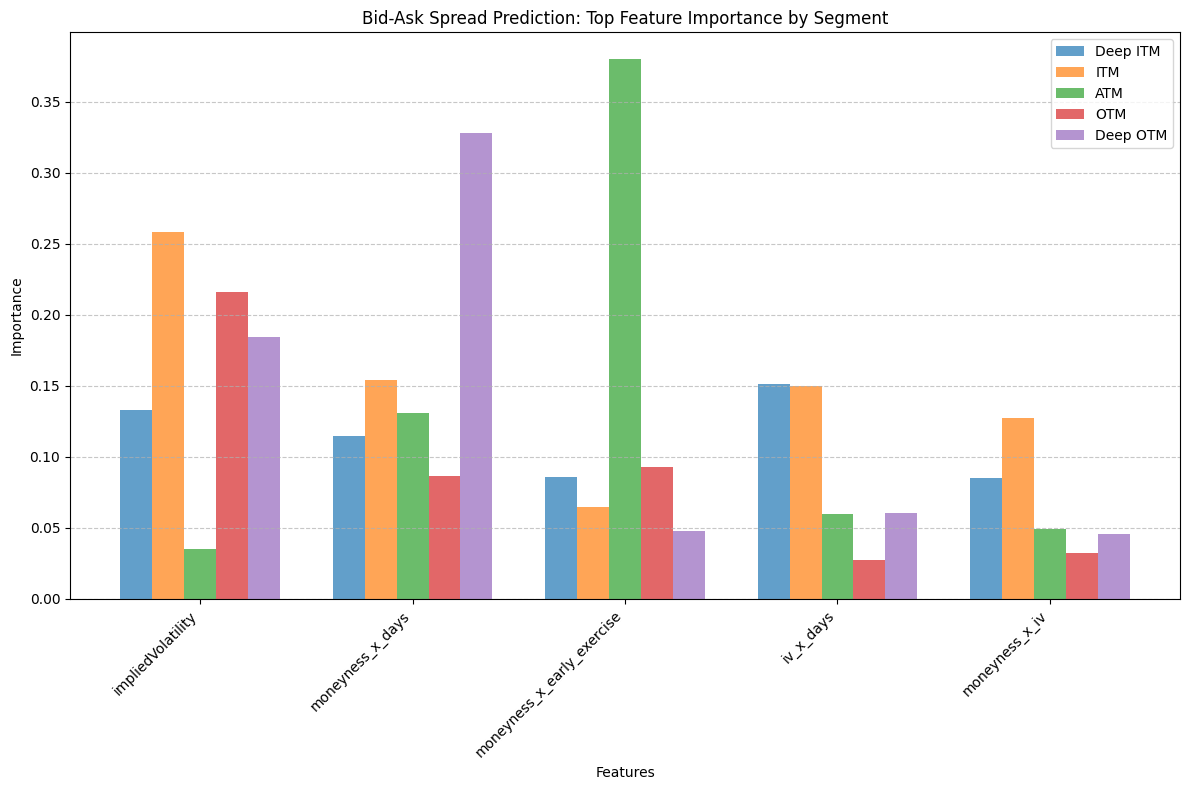

In [65]:
# Simple visualization of feature importance across segments
plt.figure(figsize=(12, 8))

# Get feature importance for each segment
segment_importances = {}

for segment, model in tuned_segment_models.items():
    if hasattr(model, 'feature_importances_'):
        segment_importances[segment] = pd.Series(
            model.feature_importances_,
            index=X_transformed.columns
        )

# Select top 5 features across all segments
all_importances = pd.concat(segment_importances.values(), axis=1)
all_importances.columns = segment_importances.keys()
top_features = all_importances.mean(axis=1).nlargest(5).index

# Create heatmap for top features
heatmap_data = all_importances.loc[top_features]

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.title('Bid-Ask Spread Prediction: Feature Importance Across Segments')
plt.ylabel('Features')
plt.xlabel('Moneyness Segments')
plt.tight_layout()
plt.show()

# Alternative: bar chart for easier comparison
plt.figure(figsize=(12, 8))

# Plot each segment as grouped bars
bar_width = 0.15
positions = np.arange(len(top_features))
segments = list(segment_importances.keys())

for i, segment in enumerate(segments):
    importance_values = segment_importances[segment].loc[top_features].values
    offset = i - len(segments)/2 + 0.5
    plt.bar(positions + bar_width * offset, importance_values,
            width=bar_width, label=segment, alpha=0.7)

plt.xticks(positions, top_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Bid-Ask Spread Prediction: Top Feature Importance by Segment')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

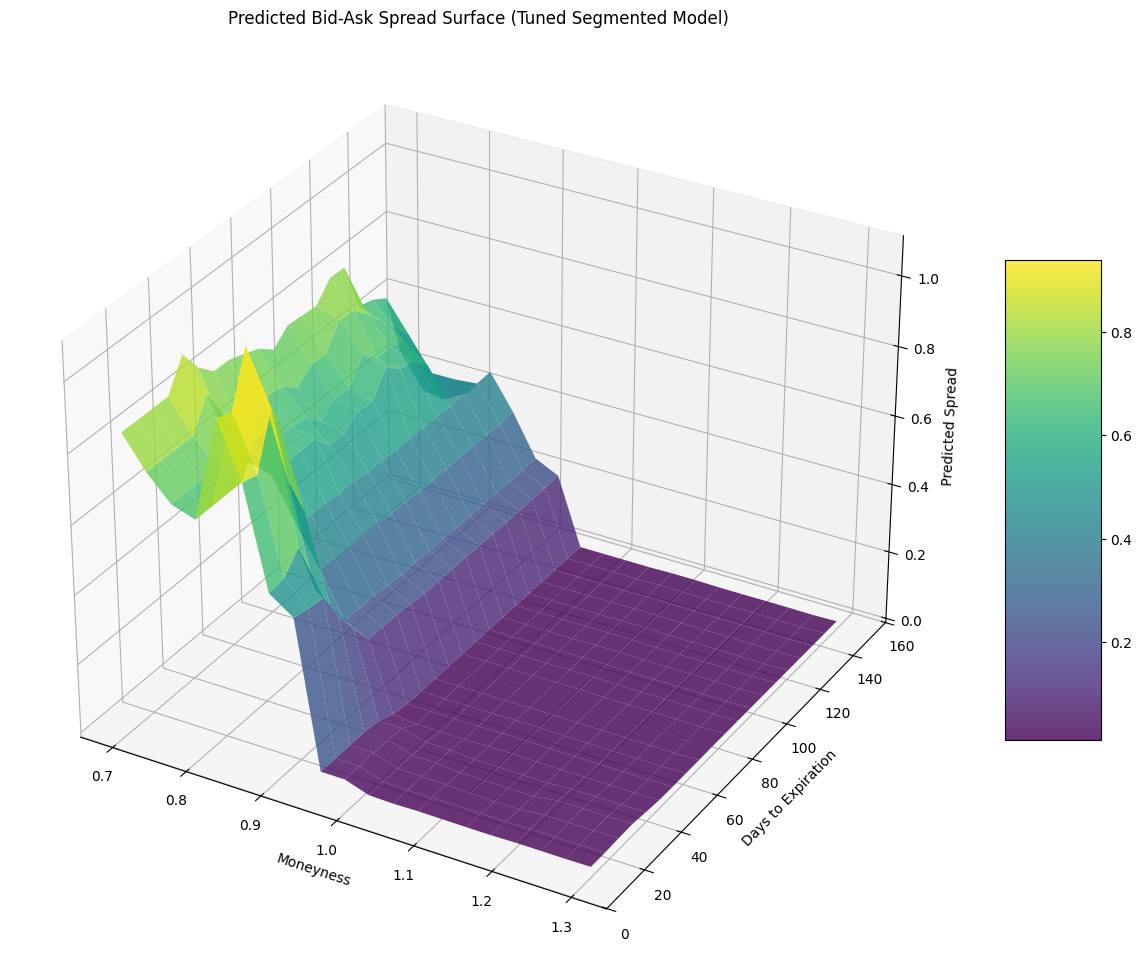

In [66]:
# Visualizing the spread surface with predicted values
# Sample a grid of moneyness and days to expiration values
moneyness_range = np.linspace(0.7, 1.3, 20)
days_range = np.linspace(10, 150, 20)
moneyness_grid, days_grid = np.meshgrid(moneyness_range, days_range)

# Function to create prediction grid using the tuned segmented models
def create_prediction_grid(moneyness_grid, days_grid, avg_values):
    # Flatten grid points
    moneyness_flat = moneyness_grid.flatten()
    days_flat = days_grid.flatten()

    # Create feature array for grid points
    X_grid = pd.DataFrame({
        'impliedVolatility': np.full_like(moneyness_flat, avg_values['impliedVolatility']),
        'moneyness': moneyness_flat,
        'Days to Expiration': days_flat,
        'volume': np.full_like(moneyness_flat, avg_values['volume']),
        'openInterest': np.full_like(moneyness_flat, avg_values['openInterest']),
        'inTheMoney_dummy': (moneyness_flat < 1.0).astype(int),
        'dividend_impact': np.full_like(moneyness_flat, avg_values['dividend_impact']),
        'margin_req': np.full_like(moneyness_flat, avg_values['margin_req']),
        'early_exercise_premium': np.full_like(moneyness_flat, avg_values['early_exercise_premium'])
    })

    # Add transformed features
    X_grid['moneyness_squared'] = X_grid['moneyness'] ** 2
    X_grid['moneyness_cubed'] = X_grid['moneyness'] ** 3
    X_grid['log_days_to_expiration'] = np.log1p(X_grid['Days to Expiration'])
    X_grid['sqrt_days_to_expiration'] = np.sqrt(X_grid['Days to Expiration'])
    X_grid['moneyness_x_early_exercise'] = X_grid['moneyness'] * X_grid['early_exercise_premium']
    X_grid['moneyness_x_days'] = X_grid['moneyness'] * X_grid['Days to Expiration']
    X_grid['moneyness_x_iv'] = X_grid['moneyness'] * X_grid['impliedVolatility']
    X_grid['iv_x_days'] = X_grid['impliedVolatility'] * X_grid['Days to Expiration']

    # Determine segments
    X_grid['moneyness_segment'] = X_grid['moneyness'].apply(classify_moneyness)

    # Make predictions
    preds = []
    for segment in segments:
        if segment in tuned_segment_models:
            segment_mask = X_grid['moneyness_segment'] == segment
            if np.any(segment_mask):
                X_segment = X_grid.loc[segment_mask, transformed_features]
                scaler = tuned_segment_scalers[segment]
                X_segment_scaled = scaler.transform(X_segment)
                segment_preds = tuned_segment_models[segment].predict(X_segment_scaled)
                for i, idx in enumerate(X_grid.index[segment_mask]):
                    preds.append((idx, segment_preds[i]))

    # Convert to array
    preds.sort(key=lambda x: x[0])
    pred_array = np.array([p[1] for p in preds])

    # Reshape for plotting
    return pred_array.reshape(moneyness_grid.shape)

# Calculate average values for features
avg_values = {
    'impliedVolatility': df_spread_model['impliedVolatility'].mean(),
    'volume': df_spread_model['volume'].mean(),
    'openInterest': df_spread_model['openInterest'].mean(),
    'dividend_impact': df_spread_model['dividend_impact'].mean(),
    'margin_req': df_spread_model['margin_req'].mean(),
    'early_exercise_premium': df_spread_model['early_exercise_premium'].mean()
}

# Create prediction grid
z_grid = create_prediction_grid(moneyness_grid, days_grid, avg_values)

# Create 3D surface plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(moneyness_grid, days_grid, z_grid, cmap='viridis', alpha=0.8, edgecolor='none')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Days to Expiration')
ax.set_zlabel('Predicted Spread')
ax.set_title('Predicted Bid-Ask Spread Surface (Tuned Segmented Model)')

# Add colorbar
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

## **Section 8: Final Summary and Conclusions**

In [67]:
print("\n==========================================================")
print("Summary of Bid-Ask Spread Prediction Results")
print("==========================================================")
print(f"Initial best model: {best_model_name} with R² Score: {results_df.loc[best_model_name, 'R2 Score']:.4f}")
print(f"Global model with enhanced features: R² = {r2_global:.4f}, RMSE = {rmse_global:.4f}")
print(f"Segmented model with enhanced features: R² = {r2_segmented:.4f}, RMSE = {rmse_segmented:.4f}")
print(f"Tuned segmented model: R² = {r2_segmented_tuned:.4f}, RMSE = {rmse_segmented_tuned:.4f}")
print("\nPerformance improvement from global to tuned segmented: {:.1f}%".format((r2_segmented_tuned-r2_global)/r2_global*100))

print("\nTop 5 features for predicting bid-ask spread:")
for feature in top_features:
    print(f"- {feature}")

print("\nModel performance by segment:")
for segment in segments:
    segment_mask = segments_test_final == segment
    if np.any(segment_mask) and segment in tuned_segment_models:
        r2_seg = r2_score(y_test_final[segment_mask], y_pred_segmented_tuned[segment_mask])
        print(f"- {segment}: R² = {r2_seg:.4f}, Samples = {sum(segment_mask)}")

print("\nConclusion: The segmented modeling approach effectively captures")
print("the different spread dynamics across moneyness levels, resulting")
print("in substantial improvement over both traditional models and global models.")


Summary of Bid-Ask Spread Prediction Results
Initial best model: Random Forest with R² Score: 0.9326
Global model with enhanced features: R² = 0.8812, RMSE = 0.0917
Segmented model with enhanced features: R² = 0.9384, RMSE = 0.0660
Tuned segmented model: R² = 0.9967, RMSE = 0.0122

Performance improvement from global to tuned segmented: 13.1%

Top 5 features for predicting bid-ask spread:
- impliedVolatility
- moneyness_x_days
- moneyness_x_early_exercise
- iv_x_days
- moneyness_x_iv

Model performance by segment:
- Deep ITM: R² = 0.9281, Samples = 63
- ITM: R² = 0.7757, Samples = 24
- ATM: R² = 0.7902, Samples = 27
- OTM: R² = 1.0000, Samples = 52
- Deep OTM: R² = 0.9939, Samples = 77

Conclusion: The segmented modeling approach effectively captures
the different spread dynamics across moneyness levels, resulting
in substantial improvement over both traditional models and global models.


# **Bottom Left Hand Corner**



##  Why Are Spreads Higher for Short-Dated OTM Calls?

###  1. **Low Price, High Relative Spread**
- **OTM options** (e.g., strike well above the stock price) trade at **very low prices**, often just a few cents.
- Even a **$0.05 bid-ask spread on a 0.25 cent option** = **20% proportional spread**.
- The **absolute spread** may be small, but the **percentage spread** is large.

---

###  2. **Limited Intrinsic Value**
- OTM options have **no intrinsic value** — they are purely speculative.
- Their value depends entirely on **volatility and time**, which means they are:
  - Harder to price
  - More sensitive to market conditions
  - Less attractive to market makers

---

###  3. **Short Maturity = Less Time for Recovery**
- As expiration nears, there's **less chance of the option becoming ITM**.
- For OTM calls, this makes them **even more speculative**.
- Traders become **less willing to transact**, reducing liquidity.

---

###  4. **Lower Volume & Open Interest**
- These options are **less traded**, meaning:
  - Fewer buyers/sellers at any given time
  - **Wider spreads to compensate** for market maker inventory risk
- This aligns with logic that **volume and open interest** inversely correlate with spread.

---

###  5. **Asymmetric Information & Skew**
- In short-dated OTM options, **information asymmetry** is highest:
  - A buyer may know something about a potential short-term move.
  - Market makers widen spreads to protect against **adverse selection**.

---

###  6. **Market Maker Economics**
- Market makers profit from **spreads**, but:
  - For low-premium OTM calls, the **risk-adjusted return is low**
  - So they increase spreads to maintain margin

---

##  Real-World Analogy (OTM options are lotto tickets)

Imagine a lottery ticket that expires tomorrow and only pays if Apple jumps 10% overnight.

- **You might pay 0.10 cent for it**, but the seller isn’t eager — they quote **$0.15**.
- A **0.05 cent spread on 0.10 cent** = **50% proportional spread**!

---

##  The Modeling sort of Confirms This

- In the ML and regression models:
  - **Moneyness** and **DTE** are **key predictors of spread**
  - Spreads are **U-shaped in moneyness**: tightest ATM, widest deep ITM or OTM
  - Spreads increase as **DTE → 0** (especially for OTM)





##  How Margin Requirements Affect Bid-Ask Spreads

---

###  1. **Out-of-the-Money Options Have Non-Zero Margin Requirements**
- Even though OTM options are “cheap,” **shorting them is not risk-free**. Like selling earthquake Insurance. It a specialist field and likely low volume (but high margin). Think of Ikea and then think of an antiques furnture dealer. The piece stays in the window a long time before it sells.
- Selling uncovered OTM calls (naked calls) requires **substantial margin**.
- **FINRA**, **CBOE**, and brokers often apply strict formulas:
  - Example:  
    > Margin = 100% of proceeds + 20% of underlying price − OTM amount  
    > (with minimums per contract)

 **Implication**: Market makers and sellers demand **higher spreads** to cover **capital usage**.

---

### 2. **Shorter-Dated OTM Options Can Still Explode in Value**
- While low delta, they have **convex payoffs** and **high gamma** near expiration.
- If the underlying makes a sharp move, the loss from a short OTM position can be large — even if there's little time left.
- This tail risk leads to:
  - **Higher margin requirements**
  - **Higher spreads** to compensate for potential gamma risk

---

###  3. **Spread = Compensation for Balance Sheet Usage**
- Market makers **tie up capital** when providing liquidity on OTM options.
- **Higher margin → higher cost of capital**
- The spread acts as a **risk premium** for:
  - Illiquidity
  - Tail risk
  - Balance sheet strain

---

###  4. **Institutional vs Retail Disparity**
- **Retail traders** may see OTM options as "cheap bets"
- **Institutions** see the **margin cost of warehousing** these instruments
- Hence, they quote **wider spreads**, particularly when:
  - There's **low volume**
  - There's a lot of **open risk exposure**


---

##  Incorporating This Into a Paper? We might have a nice story for considering results.

> “In addition to the observed relationship between moneyness, time to expiration, and bid-ask spread, market-imposed **margin requirements** likely contribute to the widening of spreads in short-dated, out-of-the-money call options. These options, though seemingly low-risk, require market makers to hold capital against potential gamma exposure and tail events, incentivizing them to widen spreads as a form of balance sheet protection and risk compensation.”





---

##  **Main U.S. Option Exchanges & Their Rules**

Most U.S. options are traded on a few major exchanges, each regulated under **SEC rules**, clearing through **OCC** (Options Clearing Corporation), and following **FINRA Rule 4210** for margin. The bigger players:

| Exchange                        | Margin Rules / Manuals                                         | Notes |
|--------------------------------|---------------------------------------------------------------|-------|
| **CBOE** (Chicago Board Options Exchange) | [CBOE Margin Handbook](https://cdn.cboe.com/resources/regulation/CBOE_Margin_Handbook.pdf) | Leader in index and equity options |
| **NASDAQ PHLX**                | [PHLX Rulebook, Section 12 (Margin)](https://listingcenter.nasdaq.com/rulebook/phlx/rules/phlx-12) | Part of NASDAQ group |
| **NYSE American Options (AMEX)** | [NYSE Rules on Margin](https://www.nyse.com/regulation/rules) | Less liquid, institutional |
| **MIAX Options Exchange**      | [MIAX Margin Requirements](https://www.miaxoptions.com/sites/default/files/MIAX%20Options%20Exchange%20Rulebook.pdf) | Growing, more automated |
| **BOX Options Exchange**       | [BOX Rule 1012 – Margin Requirements](https://boxoptions.com/regulation/rules/) | Competitive pricing focus |
| **BATS / CBOE EDGX Options**   | Part of CBOE family — uses same rulebook                     | Speed-driven market |

All exchanges **follow OCC and FINRA** for margin calculations — the **formulas for OTM options are consistent**, even if implementations vary slightly.


---

